In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from konlpy.tag import Kkma

In [22]:
data = pd.read_csv('d:/data/project/data/review_data_daum.csv')
data = data.drop('Unnamed: 0', axis=1)
data

,movie,review,score
0,명량,정말 끝내주는 영화네요.한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ,10
1,명량,한산보기전 다시 봤는데 역시 재미있네요!!,10
2,명량,명량\n실제로 거북선 불타지 않았구요 배설 해전 후에 죽었구요\n해전에서 백병전이다...,6
3,명량,명량해전 하나만 좋았다,6
4,명량,한산보고 궁금해서봤는데 명량이확실히 스토리도탄탄하고 전투씬도더박진감넘치고리얼하네요\...,8
...,...,...,...
40431,완득이,재미나게봤어요,10
40432,완득이,자연스런 전개 속에 다문화가정의 소시민적인 삶을 잘 담아냈당.ㅋ 유머도 너무재밌고 ...,10
40433,완득이,높은 평점때문에 엄청 수작일꺼라 생각했는데.. 기대치에 한참 못미쳤음; \n그래도 ...,7
40434,완득이,웃겨욬ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,10


### 리뷰 길이 및 단어수 파악

In [23]:
plt.rc('font', family='NanumGothic') 

In [24]:
# 통계 나타내주는 함수
def summary_stats(*series, labels):
    summary = [s.describe() for s in series]
    
    return pd.concat(summary, axis=1, keys=labels)

# 통계 히스토그램, 상자그림 함수
def review_plots(*series, labels):
    nc = int(len(series))
    fig, ax = plt.subplots(nrows=2, ncols=nc, figsize=(10*nc/2, 10))
    
    for i in range(nc):
        ax[0, i].hist(series[i], bins=50)
        ax[0, i].set_title(f'{labels[i]} 히스토그램', size=15)
        
        ax[1, i].boxplot(series[i], vert=False)
        ax[1, i].set_title(f'{labels[i]} 상자그림', size=15)
        ax[1, i].set_xlabel(labels[i])
    
    return ax

In [25]:
review_len = data['review'].apply(len)
review_words = data['review'].apply(lambda x: len(x.split()))

### (1) 통계

In [26]:
summary_stats(review_len, review_words, labels=['리뷰 길이', '리뷰 당 단어 수'])

,리뷰 길이,리뷰 당 단어 수
count,40436.000000,40436.000000
mean,48.467974,10.836779
std,53.305783,11.991989
min,2.000000,0.000000
25%,14.000000,3.000000
50%,30.000000,7.000000
75%,63.000000,14.000000
max,400.000000,115.000000


### (2) 그래프

array([[<AxesSubplot: title={'center': '리뷰 길이 히스토그램'}>,
        <AxesSubplot: title={'center': '리뷰 당 단어 수 히스토그램'}>],
       [<AxesSubplot: title={'center': '리뷰 길이 상자그림'}, xlabel='리뷰 길이'>,
        <AxesSubplot: title={'center': '리뷰 당 단어 수 상자그림'}, xlabel='리뷰 당 단어 수'>]],
      dtype=object)

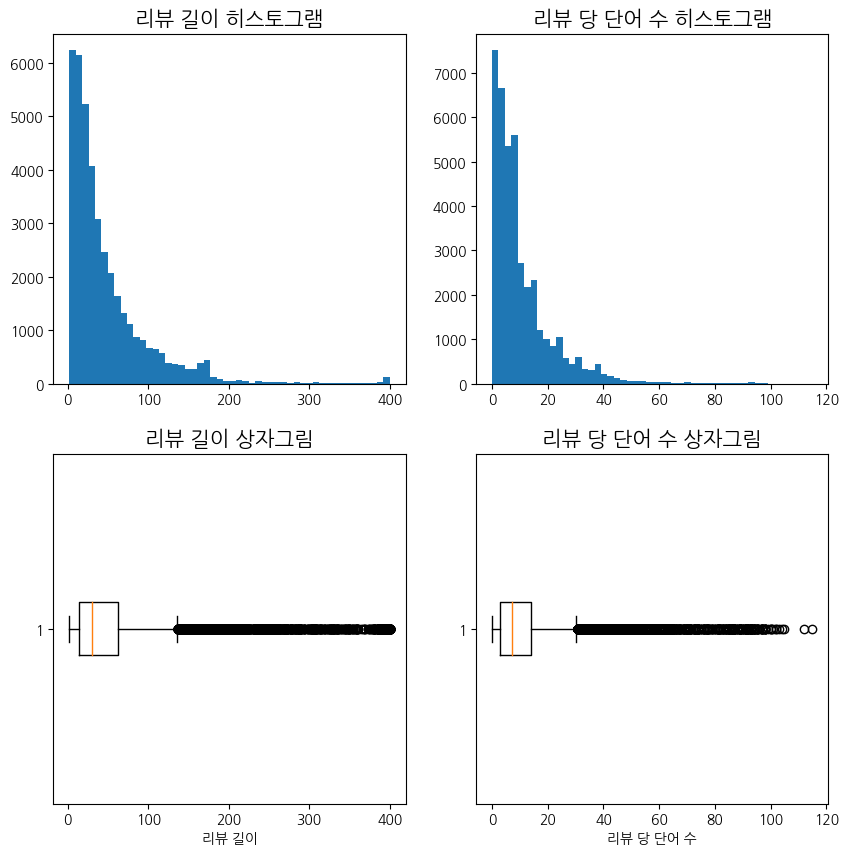

In [27]:
review_plots(review_len, review_words, labels=['리뷰 길이', '리뷰 당 단어 수'])

---

# 데이터 전처리 (Preprocessing)

- 데이터 분석과정을 바탕으로 데이터를 모델에 적용시키기 위해 전처리 과정을 진행한다.

In [28]:
import re
import json
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
data

,movie,review,score
0,명량,정말 끝내주는 영화네요.한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ,10
1,명량,한산보기전 다시 봤는데 역시 재미있네요!!,10
2,명량,명량\n실제로 거북선 불타지 않았구요 배설 해전 후에 죽었구요\n해전에서 백병전이다...,6
3,명량,명량해전 하나만 좋았다,6
4,명량,한산보고 궁금해서봤는데 명량이확실히 스토리도탄탄하고 전투씬도더박진감넘치고리얼하네요\...,8
...,...,...,...
40431,완득이,재미나게봤어요,10
40432,완득이,자연스런 전개 속에 다문화가정의 소시민적인 삶을 잘 담아냈당.ㅋ 유머도 너무재밌고 ...,10
40433,완득이,높은 평점때문에 엄청 수작일꺼라 생각했는데.. 기대치에 한참 못미쳤음; \n그래도 ...,7
40434,완득이,웃겨욬ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,10


In [30]:
## 문장 하나를 가져오기
review = data['review'][0]
review

'정말 끝내주는 영화네요.한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ'

#### (1) 한글을 제외한 나머지는 모두 공백처리 - 정규표현식
* 구두점, 물음표, 따옴표 등등 사라짐

In [31]:
review_text = re.sub('[^ㄱ-ㅎ가-힣0-9]', ' ', review)      # 한글, 숫자 아닌것들은 공백으로 표시
review_text

'정말 끝내주는 영화네요 한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ'

#### (2) split 메소드로 단어 분리

In [32]:
words = review_text.split()    # 단어 리스트
print(words)

['정말', '끝내주는', '영화네요', '한국영화', '많이', '보는', '내가', '이걸', '인제', '봤다니ㅎ']


#### (3) 한글 불용어 데이터 가져옴 (stopwords-ko.txt)

In [33]:
stopwords_data = pd.read_table('d:/data/project/data/stopwords-ko.txt')
s_words = stopwords_data['가'].tolist()
len(s_words), s_words

(594,
 ['가까스로',
  '가령',
  '각',
  '각각',
  '각자',
  '각종',
  '갖고말하자면',
  '같다',
  '같이',
  '개의치않고',
  '거니와',
  '거바',
  '거의',
  '것',
  '것과 같이',
  '것들',
  '게다가',
  '게우다',
  '겨우',
  '견지에서',
  '결과에 이르다',
  '결국',
  '결론을 낼 수 있다',
  '겸사겸사',
  '고려하면',
  '고로',
  '곧',
  '공동으로',
  '과',
  '과연',
  '관계가 있다',
  '관계없이',
  '관련이 있다',
  '관하여',
  '관한',
  '관해서는',
  '구',
  '구체적으로',
  '구토하다',
  '그',
  '그들',
  '그때',
  '그래',
  '그래도',
  '그래서',
  '그러나',
  '그러니',
  '그러니까',
  '그러면',
  '그러므로',
  '그러한즉',
  '그런 까닭에',
  '그런데',
  '그런즉',
  '그럼',
  '그럼에도 불구하고',
  '그렇게 함으로써',
  '그렇지',
  '그렇지 않다면',
  '그렇지 않으면',
  '그렇지만',
  '그렇지않으면',
  '그리고',
  '그리하여',
  '그만이다',
  '그에 따르는',
  '그위에',
  '그저',
  '그중에서',
  '그치지 않다',
  '근거로',
  '근거하여',
  '기대여',
  '기점으로',
  '기준으로',
  '기타',
  '까닭으로',
  '까악',
  '까지',
  '까지 미치다',
  '까지도',
  '꽈당',
  '끙끙',
  '끼익',
  '나',
  '나머지는',
  '남들',
  '남짓',
  '너',
  '너희',
  '너희들',
  '네',
  '넷',
  '년',
  '논하지 않다',
  '놀라다',
  '누가 알겠는가',
  '누구',
  '다른',
  '다른 방면으로',
  '다만',
  '다섯',
  '다소',
  '다수',
  '다시 말하자면',
  '다시말하면',

#### (4) 불용어 제거

In [34]:
words = [w for w in words if not w in s_words]
print(len(words), words)

10 ['정말', '끝내주는', '영화네요', '한국영화', '많이', '보는', '내가', '이걸', '인제', '봤다니ㅎ']


#### (5) 단어 리스트를 다시 하나의 글로 합치기 (데이터 정제)

In [35]:
clean_review = ' '.join(words)
len(clean_review), clean_review

(37, '정말 끝내주는 영화네요 한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ')

#### (6) PyKoSpacing(올바르게 띄어쓰기 하기)

In [106]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to c:\users\win10\appdata\local\temp\pip-req-build-ci114w2o
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit 1f8d11c59ac93525432f164e4c237ece4e298691
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow-2.9.3-cp38-cp38-win_amd64.whl (444.1 MB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2268651 sha256=49e55bbb56944a58f180f20990821b93f167d83ac77b7534729211fcd6d5d6d4
  Stored in directory: C:\Users\WIN10\AppData\Local\Temp\pip-ephem-wheel-cache-4xp5mum6\wheels\79\a0\33\16f2cd03d21f76a663f5d69a0b96f0351335385349136fbd03
Successfully built pykospacing
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Unin

  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git 'C:\Users\WIN10\AppData\Local\Temp\pip-req-build-ci114w2o'
ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\WIN10\\anaconda3\\envs\\nlp_py38\\Lib\\site-packages\\~ensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [36]:
from pykospacing import Spacing

spacing = Spacing()

# 띄어쓰기 없애기
review = clean_review.replace(" ", "")

# 띄어쓰기 변환
new_review = spacing(review)
    
print(new_review)

1/1 [==============================] - 0s 37ms/step
정말 끝내주는 영화네요한국 영화 많이 보는 내가 이걸 인제 봤다니ㅎ


In [18]:
clean_review

'정말 끝내주는 영화네요 한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ'

#### 위의 과정을 모두 통합

In [37]:
#################### 과정 정리 #############################
review = data['review'][5]
remove_stopwords = True    ## option
print("<before>\n", review)  

# 1. 한글, 숫자 아닌 특수문자들을 공백(" ")으로 바꾸기
review_text = re.sub("[^ㄱ-ㅎ가-힣0-9]", " ", review)

# 2. 공백단위로 텍스트를 나눠서 리스트로 만든다.
words = review_text.split() 

# 3. 불용어 데이터 가져오기
stopwords_data = pd.read_table('d:/data/project/data/stopwords-ko.txt')
s_words = stopwords_data['가'].tolist()

# 4. 불용어 제거 (불용어가 아닌 단어들로 이루어진 새로운 리스트 생성)
words = [w for w in words if not w in s_words]

# 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
clean_review = ' '.join(words)

# 6. 올바른 띄어쓰기
spacing = Spacing()

# 띄어쓰기 없애기
review = clean_review.replace(" ", "")

# 띄어쓰기 변환
clean_review = spacing(review)

print('\n<after>\n', clean_review)

<before>
 개인적인 생각이자 바람이지만 노량이 끝난 후에 명량을 전체적으로 손보는 투자가 있기를 희망합니다
한산, 노량과 비슷하게 편집을 하고 특수효과도 스타워즈의 사례같이 대대적으로 손보았으면 좋겠습니다
8년이라는 시간이 지났는데 최근에 다시 보니 한산에 비해 부족한 부분이 너무 많아서 아쉽습니다
명량 VFX 제작진과 배급사나 투자 주체에 따른 이해관계 때문에 못할 가능성도 있겠지만
한산과 노량을 제작하면서 시각효과에 쌓인 데이터들을 명량에도 연속해 3부작이 연결됐으면 좋겠네요
일본군들의 일본어도 일본 성우들에 의해 정확하게 발음될 수 있도록 일본 DVD판 오디오로 교체했으면 하고
이런 여러 가지 부분들을 크게 개선하도록 빅스톤에서 투자해서 재작업에 가까운 결정을 해줬으면 좋겠습니다
꿈 같은 일이지만 써봅니다 ^^
1/1 [==============================] - 0s 22ms/step

<after>
 개인적인 생각이자 바람이지만 노량이 끝난 후에 명량을 전체적으로 손보는 투자가 있기를 희망합니다 한산노량과 비슷하게 편집을 하고 특수효과도 스타워즈의 사례같이 대대적으로 손보았으면 좋겠습니다 8년이라는 시간이 지났는데 최근에 다시 보니 한 산에 비해 부족한 부분이 너무 많아서 아쉽습니다 명량 제작진과 배급사나 투자주체에 따른 이해관계 못할 가능성도 있겠지만 한산과 노량을 제작하면서 시각 효과에 쌓인데이터들을 명량에도 연속해 3부작이 연결됐으면 좋겠네 요일본군들의 일본어도 일본 성우들에 정확하게 발음될 수 있도록 일본판 오디오로 교체했으면 하고 여러 가지 부분들을 크게 개선하도록 빅스톤에서 투자해서 재작업에 가까운 결정을 해줬으면 좋겠습니다 꿈같은 일이지만 써봅니다


### 하나의 함수로 정의

In [46]:
#################### 함수 #############################
def preprocessing(review, remove_stopwords=True):  # 불용어 제거 : option  
    # 1. 한글, 숫자가 아닌 특수문자들을 공백(" ")으로 바꾸기
    review_text = re.sub("[^ㄱ-ㅎ가-힣0-9]", " ", review)

    # 2. 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.split()

    # 3. 불용어 데이터 가져오기
    stopwords_data = pd.read_table('d:/data/project/data/stopwords-ko.txt')
    s_words = stopwords_data['가'].tolist()
    
    # 4. 불용어들을 제거
    # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성 ????
    words = [w for w in words if not w in s_words]

    # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
    clean_review = ' '.join(words)
    
    # 6. 올바른 띄어쓰기 만들기
    spacing = Spacing()
         
    # 띄어쓰기 없애기
    clean_review = clean_review.replace(" ", "")

    # 띄어쓰기 변환
    clean_review = spacing(clean_review)
        
    return clean_review

### 모든 리뷰에 전처리 함수 적용

In [39]:
data['review'][:5]

0                정말 끝내주는 영화네요.한국영화 많이 보는 내가 이걸 인제 봤다니ㅎ
1                              한산보기전 다시 봤는데 역시 재미있네요!!
2    명량\n실제로 거북선 불타지 않았구요 배설 해전 후에 죽었구요\n해전에서 백병전이다...
3                                         명량해전 하나만 좋았다
4    한산보고 궁금해서봤는데 명량이확실히 스토리도탄탄하고 전투씬도더박진감넘치고리얼하네요\...
Name: review, dtype: object

In [48]:
%%time
reviews = data['review']
clean_train_reviews = []
cnt = 0
for review in reviews:
    clean_train_reviews.append(preprocessing(review, remove_stopwords = True))
    cnt += 1
    print(cnt,'/','40436')

# 전처리한 데이터 출력
clean_train_reviews[:10]

1/1 [==============================] - 0s 24ms/step
1 / 40436
1/1 [==============================] - 0s 24ms/step
2 / 40436
1/1 [==============================] - 0s 25ms/step
3 / 40436
1/1 [==============================] - 0s 27ms/step
4 / 40436
1/1 [==============================] - 0s 23ms/step
5 / 40436
1/1 [==============================] - 0s 24ms/step
6 / 40436
1/1 [==============================] - 0s 25ms/step
7 / 40436
1/1 [==============================] - 0s 25ms/step
8 / 40436
1/1 [==============================] - 0s 24ms/step
9 / 40436
1/1 [==============================] - 0s 24ms/step
10 / 40436
1/1 [==============================] - 0s 27ms/step
11 / 40436
1/1 [==============================] - 0s 25ms/step
12 / 40436
1/1 [==============================] - 0s 24ms/step
13 / 40436
1/1 [==============================] - 0s 27ms/step
14 / 40436
1/1 [==============================] - 0s 25ms/step
15 / 40436
1/1 [==============================] - 0s 27ms/step
16 / 40436
1

1/1 [==============================] - 0s 32ms/step
255 / 40436
1/1 [==============================] - 0s 26ms/step
256 / 40436
1/1 [==============================] - 0s 27ms/step
257 / 40436
1/1 [==============================] - 0s 25ms/step
258 / 40436
1/1 [==============================] - 0s 26ms/step
259 / 40436
1/1 [==============================] - 0s 30ms/step
260 / 40436
1/1 [==============================] - 0s 41ms/step
261 / 40436
1/1 [==============================] - 0s 52ms/step
262 / 40436
1/1 [==============================] - 0s 30ms/step
263 / 40436
1/1 [==============================] - 0s 26ms/step
264 / 40436
1/1 [==============================] - 0s 28ms/step
265 / 40436
1/1 [==============================] - 0s 27ms/step
266 / 40436
1/1 [==============================] - 0s 23ms/step
267 / 40436
1/1 [==============================] - 0s 26ms/step
268 / 40436
1/1 [==============================] - 0s 25ms/step
269 / 40436
1/1 [==============================] - 0

1/1 [==============================] - 0s 21ms/step
510 / 40436
1/1 [==============================] - 0s 22ms/step
511 / 40436
1/1 [==============================] - 0s 26ms/step
512 / 40436
1/1 [==============================] - 0s 26ms/step
513 / 40436
1/1 [==============================] - 0s 24ms/step
514 / 40436
1/1 [==============================] - 0s 25ms/step
515 / 40436
1/1 [==============================] - 0s 24ms/step
516 / 40436
1/1 [==============================] - 0s 23ms/step
517 / 40436
1/1 [==============================] - 0s 24ms/step
518 / 40436
1/1 [==============================] - 0s 21ms/step
519 / 40436
1/1 [==============================] - 0s 23ms/step
520 / 40436
1/1 [==============================] - 0s 27ms/step
521 / 40436
1/1 [==============================] - 0s 24ms/step
522 / 40436
1/1 [==============================] - 0s 24ms/step
523 / 40436
1/1 [==============================] - 0s 22ms/step
524 / 40436
1/1 [==============================] - 0

1/1 [==============================] - 0s 22ms/step
765 / 40436
1/1 [==============================] - 0s 23ms/step
766 / 40436
1/1 [==============================] - 0s 23ms/step
767 / 40436
1/1 [==============================] - 0s 28ms/step
768 / 40436
1/1 [==============================] - 0s 22ms/step
769 / 40436
1/1 [==============================] - 0s 23ms/step
770 / 40436
1/1 [==============================] - 0s 23ms/step
771 / 40436
1/1 [==============================] - 0s 23ms/step
772 / 40436
1/1 [==============================] - 0s 27ms/step
773 / 40436
1/1 [==============================] - 0s 24ms/step
774 / 40436
1/1 [==============================] - 0s 24ms/step
775 / 40436
1/1 [==============================] - 0s 23ms/step
776 / 40436
1/1 [==============================] - 0s 22ms/step
777 / 40436
1/1 [==============================] - 0s 23ms/step
778 / 40436
1/1 [==============================] - 0s 22ms/step
779 / 40436
1/1 [==============================] - 0

1/1 [==============================] - 0s 23ms/step
1018 / 40436
1/1 [==============================] - 0s 23ms/step
1019 / 40436
1/1 [==============================] - 0s 22ms/step
1020 / 40436
1/1 [==============================] - 0s 23ms/step
1021 / 40436
1/1 [==============================] - 0s 21ms/step
1022 / 40436
1/1 [==============================] - 0s 23ms/step
1023 / 40436
1/1 [==============================] - 0s 25ms/step
1024 / 40436
1/1 [==============================] - 0s 23ms/step
1025 / 40436
1/1 [==============================] - 0s 24ms/step
1026 / 40436
1/1 [==============================] - 0s 24ms/step
1027 / 40436
1/1 [==============================] - 0s 24ms/step
1028 / 40436
1/1 [==============================] - 0s 26ms/step
1029 / 40436
1/1 [==============================] - 0s 24ms/step
1030 / 40436
1/1 [==============================] - 0s 24ms/step
1031 / 40436
1/1 [==============================] - 0s 23ms/step
1032 / 40436
1/1 [====================

1/1 [==============================] - 0s 22ms/step
1141 / 40436
1/1 [==============================] - 0s 23ms/step
1142 / 40436
1/1 [==============================] - 0s 23ms/step
1143 / 40436
1/1 [==============================] - 0s 24ms/step
1144 / 40436
1/1 [==============================] - 0s 22ms/step
1145 / 40436
1/1 [==============================] - 0s 24ms/step
1146 / 40436
1/1 [==============================] - 0s 23ms/step
1147 / 40436
1/1 [==============================] - 0s 23ms/step
1148 / 40436
1/1 [==============================] - 0s 23ms/step
1149 / 40436
1/1 [==============================] - 0s 24ms/step
1150 / 40436
1/1 [==============================] - 0s 22ms/step
1151 / 40436
1/1 [==============================] - 0s 22ms/step
1152 / 40436
1/1 [==============================] - 0s 24ms/step
1153 / 40436
1/1 [==============================] - 0s 24ms/step
1154 / 40436
1/1 [==============================] - 0s 24ms/step
1155 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
1391 / 40436
1/1 [==============================] - 0s 24ms/step
1392 / 40436
1/1 [==============================] - 0s 23ms/step
1393 / 40436
1/1 [==============================] - 0s 22ms/step
1394 / 40436
1/1 [==============================] - 0s 22ms/step
1395 / 40436
1/1 [==============================] - 0s 24ms/step
1396 / 40436
1/1 [==============================] - 0s 23ms/step
1397 / 40436
1/1 [==============================] - 0s 23ms/step
1398 / 40436
1/1 [==============================] - 0s 25ms/step
1399 / 40436
1/1 [==============================] - 0s 23ms/step
1400 / 40436
1/1 [==============================] - 0s 25ms/step
1401 / 40436
1/1 [==============================] - 0s 23ms/step
1402 / 40436
1/1 [==============================] - 0s 24ms/step
1403 / 40436
1/1 [==============================] - 0s 23ms/step
1404 / 40436
1/1 [==============================] - 0s 23ms/step
1405 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
1643 / 40436
1/1 [==============================] - 0s 23ms/step
1644 / 40436
1/1 [==============================] - 0s 23ms/step
1645 / 40436
1/1 [==============================] - 0s 23ms/step
1646 / 40436
1/1 [==============================] - 0s 25ms/step
1647 / 40436
1/1 [==============================] - 0s 38ms/step
1648 / 40436
1/1 [==============================] - 0s 36ms/step
1649 / 40436
1/1 [==============================] - 0s 54ms/step
1650 / 40436
1/1 [==============================] - 0s 34ms/step
1651 / 40436
1/1 [==============================] - 0s 25ms/step
1652 / 40436
1/1 [==============================] - 0s 22ms/step
1653 / 40436
1/1 [==============================] - 0s 21ms/step
1654 / 40436
1/1 [==============================] - 0s 22ms/step
1655 / 40436
1/1 [==============================] - 0s 24ms/step
1656 / 40436
1/1 [==============================] - 0s 22ms/step
1657 / 40436
1/1 [====================

1/1 [==============================] - 0s 22ms/step
1892 / 40436
1/1 [==============================] - 0s 22ms/step
1893 / 40436
1/1 [==============================] - 0s 22ms/step
1894 / 40436
1/1 [==============================] - 0s 22ms/step
1895 / 40436
1/1 [==============================] - 0s 24ms/step
1896 / 40436
1/1 [==============================] - 0s 22ms/step
1897 / 40436
1/1 [==============================] - 0s 23ms/step
1898 / 40436
1/1 [==============================] - 0s 22ms/step
1899 / 40436
1/1 [==============================] - 0s 22ms/step
1900 / 40436
1/1 [==============================] - 0s 22ms/step
1901 / 40436
1/1 [==============================] - 0s 22ms/step
1902 / 40436
1/1 [==============================] - 0s 22ms/step
1903 / 40436
1/1 [==============================] - 0s 22ms/step
1904 / 40436
1/1 [==============================] - 0s 22ms/step
1905 / 40436
1/1 [==============================] - 0s 24ms/step
1906 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
2141 / 40436
1/1 [==============================] - 0s 23ms/step
2142 / 40436
1/1 [==============================] - 0s 24ms/step
2143 / 40436
1/1 [==============================] - 0s 22ms/step
2144 / 40436
1/1 [==============================] - 0s 22ms/step
2145 / 40436
1/1 [==============================] - 0s 23ms/step
2146 / 40436
1/1 [==============================] - 0s 23ms/step
2147 / 40436
1/1 [==============================] - 0s 29ms/step
2148 / 40436
1/1 [==============================] - 0s 25ms/step
2149 / 40436
1/1 [==============================] - 0s 22ms/step
2150 / 40436
1/1 [==============================] - 0s 23ms/step
2151 / 40436
1/1 [==============================] - 0s 23ms/step
2152 / 40436
1/1 [==============================] - 0s 24ms/step
2153 / 40436
1/1 [==============================] - 0s 23ms/step
2154 / 40436
1/1 [==============================] - 0s 22ms/step
2155 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
2391 / 40436
1/1 [==============================] - 0s 25ms/step
2392 / 40436
1/1 [==============================] - 0s 24ms/step
2393 / 40436
1/1 [==============================] - 0s 25ms/step
2394 / 40436
1/1 [==============================] - 0s 25ms/step
2395 / 40436
1/1 [==============================] - 0s 24ms/step
2396 / 40436
1/1 [==============================] - 0s 25ms/step
2397 / 40436
1/1 [==============================] - 0s 25ms/step
2398 / 40436
1/1 [==============================] - 0s 24ms/step
2399 / 40436
1/1 [==============================] - 0s 25ms/step
2400 / 40436
1/1 [==============================] - 0s 23ms/step
2401 / 40436
1/1 [==============================] - 0s 22ms/step
2402 / 40436
1/1 [==============================] - 0s 24ms/step
2403 / 40436
1/1 [==============================] - 0s 24ms/step
2404 / 40436
1/1 [==============================] - 0s 24ms/step
2405 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
2640 / 40436
1/1 [==============================] - 0s 21ms/step
2641 / 40436
1/1 [==============================] - 0s 22ms/step
2642 / 40436
1/1 [==============================] - 0s 23ms/step
2643 / 40436
1/1 [==============================] - 0s 22ms/step
2644 / 40436
1/1 [==============================] - 0s 23ms/step
2645 / 40436
1/1 [==============================] - 0s 24ms/step
2646 / 40436
1/1 [==============================] - 0s 23ms/step
2647 / 40436
1/1 [==============================] - 0s 23ms/step
2648 / 40436
1/1 [==============================] - 0s 23ms/step
2649 / 40436
1/1 [==============================] - 0s 22ms/step
2650 / 40436
1/1 [==============================] - 0s 23ms/step
2651 / 40436
1/1 [==============================] - 0s 24ms/step
2652 / 40436
1/1 [==============================] - 0s 24ms/step
2653 / 40436
1/1 [==============================] - 0s 23ms/step
2654 / 40436
1/1 [====================

1/1 [==============================] - 0s 22ms/step
2889 / 40436
1/1 [==============================] - 0s 22ms/step
2890 / 40436
1/1 [==============================] - 0s 21ms/step
2891 / 40436
1/1 [==============================] - 0s 23ms/step
2892 / 40436
1/1 [==============================] - 0s 22ms/step
2893 / 40436
1/1 [==============================] - 0s 23ms/step
2894 / 40436
1/1 [==============================] - 0s 24ms/step
2895 / 40436
1/1 [==============================] - 0s 24ms/step
2896 / 40436
1/1 [==============================] - 0s 24ms/step
2897 / 40436
1/1 [==============================] - 0s 23ms/step
2898 / 40436
1/1 [==============================] - 0s 21ms/step
2899 / 40436
1/1 [==============================] - 0s 23ms/step
2900 / 40436
1/1 [==============================] - 0s 22ms/step
2901 / 40436
1/1 [==============================] - 0s 23ms/step
2902 / 40436
1/1 [==============================] - 0s 23ms/step
2903 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
3141 / 40436
1/1 [==============================] - 0s 23ms/step
3142 / 40436
1/1 [==============================] - 0s 21ms/step
3143 / 40436
1/1 [==============================] - 0s 22ms/step
3144 / 40436
1/1 [==============================] - 0s 23ms/step
3145 / 40436
1/1 [==============================] - 0s 23ms/step
3146 / 40436
1/1 [==============================] - 0s 38ms/step
3147 / 40436
1/1 [==============================] - 0s 24ms/step
3148 / 40436
1/1 [==============================] - 0s 24ms/step
3149 / 40436
1/1 [==============================] - 0s 22ms/step
3150 / 40436
1/1 [==============================] - 0s 21ms/step
3151 / 40436
1/1 [==============================] - 0s 22ms/step
3152 / 40436
1/1 [==============================] - 0s 24ms/step
3153 / 40436
1/1 [==============================] - 0s 21ms/step
3154 / 40436
1/1 [==============================] - 0s 24ms/step
3155 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
3391 / 40436
1/1 [==============================] - 0s 23ms/step
3392 / 40436
1/1 [==============================] - 0s 23ms/step
3393 / 40436
1/1 [==============================] - 0s 23ms/step
3394 / 40436
1/1 [==============================] - 0s 23ms/step
3395 / 40436
1/1 [==============================] - 0s 23ms/step
3396 / 40436
1/1 [==============================] - 0s 21ms/step
3397 / 40436
1/1 [==============================] - 0s 61ms/step
3398 / 40436
1/1 [==============================] - 0s 36ms/step
3399 / 40436
1/1 [==============================] - 0s 29ms/step
3400 / 40436
1/1 [==============================] - 0s 24ms/step
3401 / 40436
1/1 [==============================] - 0s 21ms/step
3402 / 40436
1/1 [==============================] - 0s 23ms/step
3403 / 40436
1/1 [==============================] - 0s 23ms/step
3404 / 40436
1/1 [==============================] - 0s 23ms/step
3405 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
3643 / 40436
1/1 [==============================] - 0s 25ms/step
3644 / 40436
1/1 [==============================] - 0s 22ms/step
3645 / 40436
1/1 [==============================] - 0s 23ms/step
3646 / 40436
1/1 [==============================] - 0s 24ms/step
3647 / 40436
1/1 [==============================] - 0s 23ms/step
3648 / 40436
1/1 [==============================] - 0s 23ms/step
3649 / 40436
1/1 [==============================] - 0s 22ms/step
3650 / 40436
1/1 [==============================] - 0s 24ms/step
3651 / 40436
1/1 [==============================] - 0s 25ms/step
3652 / 40436
1/1 [==============================] - 0s 23ms/step
3653 / 40436
1/1 [==============================] - 0s 23ms/step
3654 / 40436
1/1 [==============================] - 0s 25ms/step
3655 / 40436
1/1 [==============================] - 0s 23ms/step
3656 / 40436
1/1 [==============================] - 0s 22ms/step
3657 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
3895 / 40436
1/1 [==============================] - 0s 24ms/step
3896 / 40436
1/1 [==============================] - 0s 23ms/step
3897 / 40436
1/1 [==============================] - 0s 22ms/step
3898 / 40436
1/1 [==============================] - 0s 24ms/step
3899 / 40436
1/1 [==============================] - 0s 25ms/step
3900 / 40436
1/1 [==============================] - 0s 24ms/step
3901 / 40436
1/1 [==============================] - 0s 26ms/step
3902 / 40436
1/1 [==============================] - 0s 24ms/step
3903 / 40436
1/1 [==============================] - 0s 23ms/step
3904 / 40436
1/1 [==============================] - 0s 26ms/step
3905 / 40436
1/1 [==============================] - 0s 24ms/step
3906 / 40436
1/1 [==============================] - 0s 25ms/step
3907 / 40436
1/1 [==============================] - 0s 25ms/step
3908 / 40436
1/1 [==============================] - 0s 25ms/step
3909 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
4144 / 40436
1/1 [==============================] - 0s 24ms/step
4145 / 40436
1/1 [==============================] - 0s 25ms/step
4146 / 40436
1/1 [==============================] - 0s 23ms/step
4147 / 40436
1/1 [==============================] - 0s 22ms/step
4148 / 40436
1/1 [==============================] - 0s 24ms/step
4149 / 40436
1/1 [==============================] - 0s 25ms/step
4150 / 40436
1/1 [==============================] - 0s 23ms/step
4151 / 40436
1/1 [==============================] - 0s 22ms/step
4152 / 40436
1/1 [==============================] - 0s 23ms/step
4153 / 40436
1/1 [==============================] - 0s 24ms/step
4154 / 40436
1/1 [==============================] - 0s 25ms/step
4155 / 40436
1/1 [==============================] - 0s 24ms/step
4156 / 40436
1/1 [==============================] - 0s 23ms/step
4157 / 40436
1/1 [==============================] - 0s 25ms/step
4158 / 40436
1/1 [====================

1/1 [==============================] - 0s 30ms/step
4393 / 40436
1/1 [==============================] - 0s 24ms/step
4394 / 40436
1/1 [==============================] - 0s 24ms/step
4395 / 40436
1/1 [==============================] - 0s 22ms/step
4396 / 40436
1/1 [==============================] - 0s 23ms/step
4397 / 40436
1/1 [==============================] - 0s 23ms/step
4398 / 40436
1/1 [==============================] - 0s 22ms/step
4399 / 40436
1/1 [==============================] - 0s 23ms/step
4400 / 40436
1/1 [==============================] - 0s 23ms/step
4401 / 40436
1/1 [==============================] - 0s 24ms/step
4402 / 40436
1/1 [==============================] - 0s 23ms/step
4403 / 40436
1/1 [==============================] - 0s 22ms/step
4404 / 40436
1/1 [==============================] - 0s 22ms/step
4405 / 40436
1/1 [==============================] - 0s 23ms/step
4406 / 40436
1/1 [==============================] - 0s 25ms/step
4407 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
4640 / 40436
1/1 [==============================] - 0s 24ms/step
4641 / 40436
1/1 [==============================] - 0s 24ms/step
4642 / 40436
1/1 [==============================] - 0s 23ms/step
4643 / 40436
1/1 [==============================] - 0s 22ms/step
4644 / 40436
1/1 [==============================] - 0s 24ms/step
4645 / 40436
1/1 [==============================] - 0s 22ms/step
4646 / 40436
1/1 [==============================] - 0s 22ms/step
4647 / 40436
1/1 [==============================] - 0s 23ms/step
4648 / 40436
1/1 [==============================] - 0s 23ms/step
4649 / 40436
1/1 [==============================] - 0s 26ms/step
4650 / 40436
1/1 [==============================] - 0s 23ms/step
4651 / 40436
1/1 [==============================] - 0s 23ms/step
4652 / 40436
1/1 [==============================] - 0s 24ms/step
4653 / 40436
1/1 [==============================] - 0s 25ms/step
4654 / 40436
1/1 [====================

1/1 [==============================] - 0s 21ms/step
4887 / 40436
1/1 [==============================] - 0s 23ms/step
4888 / 40436
1/1 [==============================] - 0s 21ms/step
4889 / 40436
1/1 [==============================] - 0s 23ms/step
4890 / 40436
1/1 [==============================] - 0s 21ms/step
4891 / 40436
1/1 [==============================] - 0s 23ms/step
4892 / 40436
1/1 [==============================] - 0s 22ms/step
4893 / 40436
1/1 [==============================] - 0s 22ms/step
4894 / 40436
1/1 [==============================] - 0s 22ms/step
4895 / 40436
1/1 [==============================] - 0s 23ms/step
4896 / 40436
1/1 [==============================] - 0s 22ms/step
4897 / 40436
1/1 [==============================] - 0s 22ms/step
4898 / 40436
1/1 [==============================] - 0s 24ms/step
4899 / 40436
1/1 [==============================] - 0s 22ms/step
4900 / 40436
1/1 [==============================] - 0s 22ms/step
4901 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
5135 / 40436
1/1 [==============================] - 0s 23ms/step
5136 / 40436
1/1 [==============================] - 0s 23ms/step
5137 / 40436
1/1 [==============================] - 0s 24ms/step
5138 / 40436
1/1 [==============================] - 0s 22ms/step
5139 / 40436
1/1 [==============================] - 0s 24ms/step
5140 / 40436
1/1 [==============================] - 0s 23ms/step
5141 / 40436
1/1 [==============================] - 0s 23ms/step
5142 / 40436
1/1 [==============================] - 0s 23ms/step
5143 / 40436
1/1 [==============================] - 0s 24ms/step
5144 / 40436
1/1 [==============================] - 0s 21ms/step
5145 / 40436
1/1 [==============================] - 0s 24ms/step
5146 / 40436
1/1 [==============================] - 0s 24ms/step
5147 / 40436
1/1 [==============================] - 0s 24ms/step
5148 / 40436
1/1 [==============================] - 0s 24ms/step
5149 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
5384 / 40436
1/1 [==============================] - 0s 23ms/step
5385 / 40436
1/1 [==============================] - 0s 23ms/step
5386 / 40436
1/1 [==============================] - 0s 24ms/step
5387 / 40436
1/1 [==============================] - 0s 23ms/step
5388 / 40436
1/1 [==============================] - 0s 26ms/step
5389 / 40436
1/1 [==============================] - 0s 23ms/step
5390 / 40436
1/1 [==============================] - 0s 24ms/step
5391 / 40436
1/1 [==============================] - 0s 23ms/step
5392 / 40436
1/1 [==============================] - 0s 23ms/step
5393 / 40436
1/1 [==============================] - 0s 22ms/step
5394 / 40436
1/1 [==============================] - 0s 23ms/step
5395 / 40436
1/1 [==============================] - 0s 24ms/step
5396 / 40436
1/1 [==============================] - 0s 25ms/step
5397 / 40436
1/1 [==============================] - 0s 24ms/step
5398 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
5636 / 40436
1/1 [==============================] - 0s 28ms/step
5637 / 40436
1/1 [==============================] - 0s 24ms/step
5638 / 40436
1/1 [==============================] - 0s 23ms/step
5639 / 40436
1/1 [==============================] - 0s 23ms/step
5640 / 40436
1/1 [==============================] - 0s 22ms/step
5641 / 40436
1/1 [==============================] - 0s 24ms/step
5642 / 40436
1/1 [==============================] - 0s 26ms/step
5643 / 40436
1/1 [==============================] - 0s 26ms/step
5644 / 40436
1/1 [==============================] - 0s 24ms/step
5645 / 40436
1/1 [==============================] - 0s 23ms/step
5646 / 40436
1/1 [==============================] - 0s 23ms/step
5647 / 40436
1/1 [==============================] - 0s 25ms/step
5648 / 40436
1/1 [==============================] - 0s 24ms/step
5649 / 40436
1/1 [==============================] - 0s 23ms/step
5650 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
5884 / 40436
1/1 [==============================] - 0s 23ms/step
5885 / 40436
1/1 [==============================] - 0s 23ms/step
5886 / 40436
1/1 [==============================] - 0s 26ms/step
5887 / 40436
1/1 [==============================] - 0s 25ms/step
5888 / 40436
1/1 [==============================] - 0s 21ms/step
5889 / 40436
1/1 [==============================] - 0s 23ms/step
5890 / 40436
1/1 [==============================] - 0s 21ms/step
5891 / 40436
1/1 [==============================] - 0s 21ms/step
5892 / 40436
1/1 [==============================] - 0s 21ms/step
5893 / 40436
1/1 [==============================] - 0s 23ms/step
5894 / 40436
1/1 [==============================] - 0s 22ms/step
5895 / 40436
1/1 [==============================] - 0s 23ms/step
5896 / 40436
1/1 [==============================] - 0s 24ms/step
5897 / 40436
1/1 [==============================] - 0s 23ms/step
5898 / 40436
1/1 [====================

1/1 [==============================] - 0s 26ms/step
6130 / 40436
1/1 [==============================] - 0s 25ms/step
6131 / 40436
1/1 [==============================] - 0s 23ms/step
6132 / 40436
1/1 [==============================] - 0s 22ms/step
6133 / 40436
1/1 [==============================] - 0s 24ms/step
6134 / 40436
1/1 [==============================] - 0s 22ms/step
6135 / 40436
1/1 [==============================] - 0s 24ms/step
6136 / 40436
1/1 [==============================] - 0s 24ms/step
6137 / 40436
1/1 [==============================] - 0s 24ms/step
6138 / 40436
1/1 [==============================] - 0s 23ms/step
6139 / 40436
1/1 [==============================] - 0s 22ms/step
6140 / 40436
1/1 [==============================] - 0s 22ms/step
6141 / 40436
1/1 [==============================] - 0s 25ms/step
6142 / 40436
1/1 [==============================] - 0s 23ms/step
6143 / 40436
1/1 [==============================] - 0s 24ms/step
6144 / 40436
1/1 [====================

1/1 [==============================] - 0s 22ms/step
6381 / 40436
1/1 [==============================] - 0s 24ms/step
6382 / 40436
1/1 [==============================] - 0s 24ms/step
6383 / 40436
1/1 [==============================] - 0s 26ms/step
6384 / 40436
1/1 [==============================] - 0s 27ms/step
6385 / 40436
1/1 [==============================] - 0s 28ms/step
6386 / 40436
1/1 [==============================] - 0s 26ms/step
6387 / 40436
1/1 [==============================] - 0s 26ms/step
6388 / 40436
1/1 [==============================] - 0s 24ms/step
6389 / 40436
1/1 [==============================] - 0s 28ms/step
6390 / 40436
1/1 [==============================] - 0s 24ms/step
6391 / 40436
1/1 [==============================] - 0s 23ms/step
6392 / 40436
1/1 [==============================] - 0s 23ms/step
6393 / 40436
1/1 [==============================] - 0s 22ms/step
6394 / 40436
1/1 [==============================] - 0s 25ms/step
6395 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
6504 / 40436
1/1 [==============================] - 0s 30ms/step
6505 / 40436
1/1 [==============================] - 0s 36ms/step
6506 / 40436
1/1 [==============================] - 0s 30ms/step
6507 / 40436
1/1 [==============================] - 0s 30ms/step
6508 / 40436
1/1 [==============================] - 0s 25ms/step
6509 / 40436
1/1 [==============================] - 0s 28ms/step
6510 / 40436
1/1 [==============================] - 0s 27ms/step
6511 / 40436
1/1 [==============================] - 0s 26ms/step
6512 / 40436
1/1 [==============================] - 0s 27ms/step
6513 / 40436
1/1 [==============================] - 0s 26ms/step
6514 / 40436
1/1 [==============================] - 0s 26ms/step
6515 / 40436
1/1 [==============================] - 0s 50ms/step
6516 / 40436
1/1 [==============================] - 0s 34ms/step
6517 / 40436
1/1 [==============================] - 0s 25ms/step
6518 / 40436
1/1 [====================

1/1 [==============================] - 0s 29ms/step
6755 / 40436
1/1 [==============================] - 0s 29ms/step
6756 / 40436
1/1 [==============================] - 0s 30ms/step
6757 / 40436
1/1 [==============================] - 0s 27ms/step
6758 / 40436
1/1 [==============================] - 0s 31ms/step
6759 / 40436
1/1 [==============================] - 0s 29ms/step
6760 / 40436
1/1 [==============================] - 0s 25ms/step
6761 / 40436
1/1 [==============================] - 0s 25ms/step
6762 / 40436
1/1 [==============================] - 0s 25ms/step
6763 / 40436
1/1 [==============================] - 0s 26ms/step
6764 / 40436
1/1 [==============================] - 0s 25ms/step
6765 / 40436
1/1 [==============================] - 0s 25ms/step
6766 / 40436
1/1 [==============================] - 0s 26ms/step
6767 / 40436
1/1 [==============================] - 0s 25ms/step
6768 / 40436
1/1 [==============================] - 0s 29ms/step
6769 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
7006 / 40436
1/1 [==============================] - 0s 23ms/step
7007 / 40436
1/1 [==============================] - 0s 24ms/step
7008 / 40436
1/1 [==============================] - 0s 24ms/step
7009 / 40436
1/1 [==============================] - 0s 22ms/step
7010 / 40436
1/1 [==============================] - 0s 26ms/step
7011 / 40436
1/1 [==============================] - 0s 26ms/step
7012 / 40436
1/1 [==============================] - 0s 26ms/step
7013 / 40436
1/1 [==============================] - 0s 25ms/step
7014 / 40436
1/1 [==============================] - 0s 24ms/step
7015 / 40436
1/1 [==============================] - 0s 26ms/step
7016 / 40436
1/1 [==============================] - 0s 26ms/step
7017 / 40436
1/1 [==============================] - 0s 24ms/step
7018 / 40436
1/1 [==============================] - 0s 23ms/step
7019 / 40436
1/1 [==============================] - 0s 24ms/step
7020 / 40436
1/1 [====================

1/1 [==============================] - 0s 25ms/step
7258 / 40436
1/1 [==============================] - 0s 25ms/step
7259 / 40436
1/1 [==============================] - 0s 25ms/step
7260 / 40436
1/1 [==============================] - 0s 24ms/step
7261 / 40436
1/1 [==============================] - 0s 23ms/step
7262 / 40436
1/1 [==============================] - 0s 22ms/step
7263 / 40436
1/1 [==============================] - 0s 23ms/step
7264 / 40436
1/1 [==============================] - 0s 24ms/step
7265 / 40436
1/1 [==============================] - 0s 24ms/step
7266 / 40436
1/1 [==============================] - 0s 24ms/step
7267 / 40436
1/1 [==============================] - 0s 25ms/step
7268 / 40436
1/1 [==============================] - 0s 24ms/step
7269 / 40436
1/1 [==============================] - 0s 23ms/step
7270 / 40436
1/1 [==============================] - 0s 23ms/step
7271 / 40436
1/1 [==============================] - 0s 23ms/step
7272 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
7510 / 40436
1/1 [==============================] - 0s 23ms/step
7511 / 40436
1/1 [==============================] - 0s 32ms/step
7512 / 40436
1/1 [==============================] - 0s 25ms/step
7513 / 40436
1/1 [==============================] - 0s 24ms/step
7514 / 40436
1/1 [==============================] - 0s 27ms/step
7515 / 40436
1/1 [==============================] - 0s 24ms/step
7516 / 40436
1/1 [==============================] - 0s 23ms/step
7517 / 40436
1/1 [==============================] - 0s 22ms/step
7518 / 40436
1/1 [==============================] - 0s 24ms/step
7519 / 40436
1/1 [==============================] - 0s 22ms/step
7520 / 40436
1/1 [==============================] - 0s 23ms/step
7521 / 40436
1/1 [==============================] - 0s 25ms/step
7522 / 40436
1/1 [==============================] - 0s 46ms/step
7523 / 40436
1/1 [==============================] - 0s 29ms/step
7524 / 40436
1/1 [====================

1/1 [==============================] - 0s 26ms/step
7762 / 40436
1/1 [==============================] - 0s 25ms/step
7763 / 40436
1/1 [==============================] - 0s 26ms/step
7764 / 40436
1/1 [==============================] - 0s 31ms/step
7765 / 40436
1/1 [==============================] - 0s 25ms/step
7766 / 40436
1/1 [==============================] - 0s 26ms/step
7767 / 40436
1/1 [==============================] - 0s 23ms/step
7768 / 40436
1/1 [==============================] - 0s 22ms/step
7769 / 40436
1/1 [==============================] - 0s 23ms/step
7770 / 40436
1/1 [==============================] - 0s 23ms/step
7771 / 40436
1/1 [==============================] - 0s 23ms/step
7772 / 40436
1/1 [==============================] - 0s 25ms/step
7773 / 40436
1/1 [==============================] - 0s 25ms/step
7774 / 40436
1/1 [==============================] - 0s 24ms/step
7775 / 40436
1/1 [==============================] - 0s 22ms/step
7776 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
8010 / 40436
1/1 [==============================] - 0s 24ms/step
8011 / 40436
1/1 [==============================] - 0s 22ms/step
8012 / 40436
1/1 [==============================] - 0s 23ms/step
8013 / 40436
1/1 [==============================] - 0s 27ms/step
8014 / 40436
1/1 [==============================] - 0s 24ms/step
8015 / 40436
1/1 [==============================] - 0s 23ms/step
8016 / 40436
1/1 [==============================] - 0s 25ms/step
8017 / 40436
1/1 [==============================] - 0s 23ms/step
8018 / 40436
1/1 [==============================] - 0s 24ms/step
8019 / 40436
1/1 [==============================] - 0s 24ms/step
8020 / 40436
1/1 [==============================] - 0s 24ms/step
8021 / 40436
1/1 [==============================] - 0s 25ms/step
8022 / 40436
1/1 [==============================] - 0s 24ms/step
8023 / 40436
1/1 [==============================] - 0s 23ms/step
8024 / 40436
1/1 [====================

1/1 [==============================] - 0s 24ms/step
8258 / 40436
1/1 [==============================] - 0s 24ms/step
8259 / 40436
1/1 [==============================] - 0s 24ms/step
8260 / 40436
1/1 [==============================] - 0s 24ms/step
8261 / 40436
1/1 [==============================] - 0s 25ms/step
8262 / 40436
1/1 [==============================] - 0s 26ms/step
8263 / 40436
1/1 [==============================] - 0s 24ms/step
8264 / 40436
1/1 [==============================] - 0s 25ms/step
8265 / 40436
1/1 [==============================] - 0s 23ms/step
8266 / 40436
1/1 [==============================] - 0s 22ms/step
8267 / 40436
1/1 [==============================] - 0s 26ms/step
8268 / 40436
1/1 [==============================] - 0s 24ms/step
8269 / 40436
1/1 [==============================] - 0s 24ms/step
8270 / 40436
1/1 [==============================] - 0s 24ms/step
8271 / 40436
1/1 [==============================] - 0s 23ms/step
8272 / 40436
1/1 [====================

1/1 [==============================] - 0s 22ms/step
8508 / 40436
1/1 [==============================] - 0s 23ms/step
8509 / 40436
1/1 [==============================] - 0s 23ms/step
8510 / 40436
1/1 [==============================] - 0s 23ms/step
8511 / 40436
1/1 [==============================] - 0s 25ms/step
8512 / 40436
1/1 [==============================] - 0s 24ms/step
8513 / 40436
1/1 [==============================] - 0s 24ms/step
8514 / 40436
1/1 [==============================] - 0s 23ms/step
8515 / 40436
1/1 [==============================] - 0s 24ms/step
8516 / 40436
1/1 [==============================] - 0s 24ms/step
8517 / 40436
1/1 [==============================] - 0s 24ms/step
8518 / 40436
1/1 [==============================] - 0s 23ms/step
8519 / 40436
1/1 [==============================] - 0s 24ms/step
8520 / 40436
1/1 [==============================] - 0s 22ms/step
8521 / 40436
1/1 [==============================] - 0s 25ms/step
8522 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
8757 / 40436
1/1 [==============================] - 0s 23ms/step
8758 / 40436
1/1 [==============================] - 0s 23ms/step
8759 / 40436
1/1 [==============================] - 0s 25ms/step
8760 / 40436
1/1 [==============================] - 0s 25ms/step
8761 / 40436
1/1 [==============================] - 0s 25ms/step
8762 / 40436
1/1 [==============================] - 0s 23ms/step
8763 / 40436
1/1 [==============================] - 0s 25ms/step
8764 / 40436
1/1 [==============================] - 0s 23ms/step
8765 / 40436
1/1 [==============================] - 0s 23ms/step
8766 / 40436
1/1 [==============================] - 0s 28ms/step
8767 / 40436
1/1 [==============================] - 0s 23ms/step
8768 / 40436
1/1 [==============================] - 0s 23ms/step
8769 / 40436
1/1 [==============================] - 0s 24ms/step
8770 / 40436
1/1 [==============================] - 0s 22ms/step
8771 / 40436
1/1 [====================

1/1 [==============================] - 0s 25ms/step
9008 / 40436
1/1 [==============================] - 0s 24ms/step
9009 / 40436
1/1 [==============================] - 0s 24ms/step
9010 / 40436
1/1 [==============================] - 0s 25ms/step
9011 / 40436
1/1 [==============================] - 0s 24ms/step
9012 / 40436
1/1 [==============================] - 0s 24ms/step
9013 / 40436
1/1 [==============================] - 0s 25ms/step
9014 / 40436
1/1 [==============================] - 0s 25ms/step
9015 / 40436
1/1 [==============================] - 0s 26ms/step
9016 / 40436
1/1 [==============================] - 0s 23ms/step
9017 / 40436
1/1 [==============================] - 0s 23ms/step
9018 / 40436
1/1 [==============================] - 0s 23ms/step
9019 / 40436
1/1 [==============================] - 0s 25ms/step
9020 / 40436
1/1 [==============================] - 0s 23ms/step
9021 / 40436
1/1 [==============================] - 0s 25ms/step
9022 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
9256 / 40436
1/1 [==============================] - 0s 24ms/step
9257 / 40436
1/1 [==============================] - 0s 23ms/step
9258 / 40436
1/1 [==============================] - 0s 23ms/step
9259 / 40436
1/1 [==============================] - 0s 22ms/step
9260 / 40436
1/1 [==============================] - 0s 23ms/step
9261 / 40436
1/1 [==============================] - 0s 23ms/step
9262 / 40436
1/1 [==============================] - 0s 24ms/step
9263 / 40436
1/1 [==============================] - 0s 23ms/step
9264 / 40436
1/1 [==============================] - 0s 25ms/step
9265 / 40436
1/1 [==============================] - 0s 24ms/step
9266 / 40436
1/1 [==============================] - 0s 23ms/step
9267 / 40436
1/1 [==============================] - 0s 25ms/step
9268 / 40436
1/1 [==============================] - 0s 23ms/step
9269 / 40436
1/1 [==============================] - 0s 22ms/step
9270 / 40436
1/1 [====================

1/1 [==============================] - 0s 22ms/step
9502 / 40436
1/1 [==============================] - 0s 23ms/step
9503 / 40436
1/1 [==============================] - 0s 22ms/step
9504 / 40436
1/1 [==============================] - 0s 22ms/step
9505 / 40436
1/1 [==============================] - 0s 24ms/step
9506 / 40436
1/1 [==============================] - 0s 24ms/step
9507 / 40436
1/1 [==============================] - 0s 25ms/step
9508 / 40436
1/1 [==============================] - 0s 25ms/step
9509 / 40436
1/1 [==============================] - 0s 25ms/step
9510 / 40436
1/1 [==============================] - 0s 23ms/step
9511 / 40436
1/1 [==============================] - 0s 26ms/step
9512 / 40436
1/1 [==============================] - 0s 24ms/step
9513 / 40436
1/1 [==============================] - 0s 29ms/step
9514 / 40436
1/1 [==============================] - 0s 27ms/step
9515 / 40436
1/1 [==============================] - 0s 25ms/step
9516 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
9752 / 40436
1/1 [==============================] - 0s 23ms/step
9753 / 40436
1/1 [==============================] - 0s 24ms/step
9754 / 40436
1/1 [==============================] - 0s 24ms/step
9755 / 40436
1/1 [==============================] - 0s 21ms/step
9756 / 40436
1/1 [==============================] - 0s 22ms/step
9757 / 40436
1/1 [==============================] - 0s 21ms/step
9758 / 40436
1/1 [==============================] - 0s 22ms/step
9759 / 40436
1/1 [==============================] - 0s 22ms/step
9760 / 40436
1/1 [==============================] - 0s 24ms/step
9761 / 40436
1/1 [==============================] - 0s 23ms/step
9762 / 40436
1/1 [==============================] - 0s 23ms/step
9763 / 40436
1/1 [==============================] - 0s 22ms/step
9764 / 40436
1/1 [==============================] - 0s 22ms/step
9765 / 40436
1/1 [==============================] - 0s 29ms/step
9766 / 40436
1/1 [====================

1/1 [==============================] - 0s 23ms/step
10004 / 40436
1/1 [==============================] - 0s 22ms/step
10005 / 40436
1/1 [==============================] - 0s 24ms/step
10006 / 40436
1/1 [==============================] - 0s 37ms/step
10007 / 40436
1/1 [==============================] - 0s 31ms/step
10008 / 40436
1/1 [==============================] - 0s 25ms/step
10009 / 40436
1/1 [==============================] - 0s 26ms/step
10010 / 40436
1/1 [==============================] - 0s 24ms/step
10011 / 40436
1/1 [==============================] - 0s 23ms/step
10012 / 40436
1/1 [==============================] - 0s 24ms/step
10013 / 40436
1/1 [==============================] - 0s 25ms/step
10014 / 40436
1/1 [==============================] - 0s 24ms/step
10015 / 40436
1/1 [==============================] - 0s 26ms/step
10016 / 40436
1/1 [==============================] - 0s 24ms/step
10017 / 40436
1/1 [==============================] - 0s 25ms/step
10018 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
10250 / 40436
1/1 [==============================] - 0s 25ms/step
10251 / 40436
1/1 [==============================] - 0s 24ms/step
10252 / 40436
1/1 [==============================] - 0s 24ms/step
10253 / 40436
1/1 [==============================] - 0s 25ms/step
10254 / 40436
1/1 [==============================] - 0s 25ms/step
10255 / 40436
1/1 [==============================] - 0s 25ms/step
10256 / 40436
1/1 [==============================] - 0s 23ms/step
10257 / 40436
1/1 [==============================] - 0s 25ms/step
10258 / 40436
1/1 [==============================] - 0s 26ms/step
10259 / 40436
1/1 [==============================] - 0s 23ms/step
10260 / 40436
1/1 [==============================] - 0s 23ms/step
10261 / 40436
1/1 [==============================] - 0s 23ms/step
10262 / 40436
1/1 [==============================] - 0s 24ms/step
10263 / 40436
1/1 [==============================] - 0s 25ms/step
10264 / 40436
1/1 [=====

10495 / 40436
1/1 [==============================] - 0s 28ms/step
10496 / 40436
1/1 [==============================] - 0s 27ms/step
10497 / 40436
1/1 [==============================] - 0s 28ms/step
10498 / 40436
1/1 [==============================] - 0s 27ms/step
10499 / 40436
1/1 [==============================] - 0s 28ms/step
10500 / 40436
1/1 [==============================] - 0s 26ms/step
10501 / 40436
1/1 [==============================] - 0s 26ms/step
10502 / 40436
1/1 [==============================] - 0s 28ms/step
10503 / 40436
1/1 [==============================] - 0s 32ms/step
10504 / 40436
1/1 [==============================] - 0s 32ms/step
10505 / 40436
1/1 [==============================] - 0s 23ms/step
10506 / 40436
1/1 [==============================] - 0s 24ms/step
10507 / 40436
1/1 [==============================] - 0s 32ms/step
10508 / 40436
1/1 [==============================] - 0s 23ms/step
10509 / 40436
1/1 [==============================] - 0s 26ms/step
10510 / 40

1/1 [==============================] - 0s 25ms/step
10741 / 40436
1/1 [==============================] - 0s 24ms/step
10742 / 40436
1/1 [==============================] - 0s 24ms/step
10743 / 40436
1/1 [==============================] - 0s 26ms/step
10744 / 40436
1/1 [==============================] - 0s 27ms/step
10745 / 40436
1/1 [==============================] - 0s 26ms/step
10746 / 40436
1/1 [==============================] - 0s 26ms/step
10747 / 40436
1/1 [==============================] - 0s 28ms/step
10748 / 40436
1/1 [==============================] - 0s 24ms/step
10749 / 40436
1/1 [==============================] - 0s 26ms/step
10750 / 40436
1/1 [==============================] - 0s 25ms/step
10751 / 40436
1/1 [==============================] - 0s 24ms/step
10752 / 40436
1/1 [==============================] - 0s 25ms/step
10753 / 40436
1/1 [==============================] - 0s 24ms/step
10754 / 40436
1/1 [==============================] - 0s 25ms/step
10755 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
10988 / 40436
1/1 [==============================] - 0s 24ms/step
10989 / 40436
1/1 [==============================] - 0s 24ms/step
10990 / 40436
1/1 [==============================] - 0s 25ms/step
10991 / 40436
1/1 [==============================] - 0s 25ms/step
10992 / 40436
1/1 [==============================] - 0s 24ms/step
10993 / 40436
1/1 [==============================] - 0s 27ms/step
10994 / 40436
1/1 [==============================] - 0s 46ms/step
10995 / 40436
1/1 [==============================] - 0s 36ms/step
10996 / 40436
1/1 [==============================] - 0s 26ms/step
10997 / 40436
1/1 [==============================] - 0s 27ms/step
10998 / 40436
1/1 [==============================] - 0s 25ms/step
10999 / 40436
1/1 [==============================] - 0s 21ms/step
11000 / 40436
1/1 [==============================] - 0s 25ms/step
11001 / 40436
1/1 [==============================] - 0s 22ms/step
11002 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
11235 / 40436
1/1 [==============================] - 0s 25ms/step
11236 / 40436
1/1 [==============================] - 0s 23ms/step
11237 / 40436
1/1 [==============================] - 0s 25ms/step
11238 / 40436
1/1 [==============================] - 0s 23ms/step
11239 / 40436
1/1 [==============================] - 0s 23ms/step
11240 / 40436
1/1 [==============================] - 0s 21ms/step
11241 / 40436
1/1 [==============================] - 0s 24ms/step
11242 / 40436
1/1 [==============================] - 0s 22ms/step
11243 / 40436
1/1 [==============================] - 0s 26ms/step
11244 / 40436
1/1 [==============================] - 0s 28ms/step
11245 / 40436
1/1 [==============================] - 0s 27ms/step
11246 / 40436
1/1 [==============================] - 0s 25ms/step
11247 / 40436
1/1 [==============================] - 0s 26ms/step
11248 / 40436
1/1 [==============================] - 0s 26ms/step
11249 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
11482 / 40436
1/1 [==============================] - 0s 24ms/step
11483 / 40436
1/1 [==============================] - 0s 25ms/step
11484 / 40436
1/1 [==============================] - 0s 23ms/step
11485 / 40436
1/1 [==============================] - 0s 25ms/step
11486 / 40436
1/1 [==============================] - 0s 27ms/step
11487 / 40436
1/1 [==============================] - 0s 28ms/step
11488 / 40436
1/1 [==============================] - 0s 26ms/step
11489 / 40436
1/1 [==============================] - 0s 24ms/step
11490 / 40436
1/1 [==============================] - 0s 25ms/step
11491 / 40436
1/1 [==============================] - 0s 27ms/step
11492 / 40436
1/1 [==============================] - 0s 24ms/step
11493 / 40436
1/1 [==============================] - 0s 24ms/step
11494 / 40436
1/1 [==============================] - 0s 24ms/step
11495 / 40436
1/1 [==============================] - 0s 27ms/step
11496 / 40436
1/1 [=====

1/1 [==============================] - 0s 23ms/step
11730 / 40436
1/1 [==============================] - 0s 24ms/step
11731 / 40436
1/1 [==============================] - 0s 22ms/step
11732 / 40436
1/1 [==============================] - 0s 24ms/step
11733 / 40436
1/1 [==============================] - 0s 24ms/step
11734 / 40436
1/1 [==============================] - 0s 22ms/step
11735 / 40436
1/1 [==============================] - 0s 22ms/step
11736 / 40436
1/1 [==============================] - 0s 24ms/step
11737 / 40436
1/1 [==============================] - 0s 24ms/step
11738 / 40436
1/1 [==============================] - 0s 23ms/step
11739 / 40436
1/1 [==============================] - 0s 23ms/step
11740 / 40436
1/1 [==============================] - 0s 26ms/step
11741 / 40436
1/1 [==============================] - 0s 22ms/step
11742 / 40436
1/1 [==============================] - 0s 24ms/step
11743 / 40436
1/1 [==============================] - 0s 24ms/step
11744 / 40436
1/1 [=====

11851 / 40436
1/1 [==============================] - 0s 24ms/step
11852 / 40436
1/1 [==============================] - 0s 23ms/step
11853 / 40436
1/1 [==============================] - 0s 22ms/step
11854 / 40436
1/1 [==============================] - 0s 24ms/step
11855 / 40436
1/1 [==============================] - 0s 24ms/step
11856 / 40436
1/1 [==============================] - 0s 25ms/step
11857 / 40436
1/1 [==============================] - 0s 24ms/step
11858 / 40436
1/1 [==============================] - 0s 24ms/step
11859 / 40436
1/1 [==============================] - 0s 24ms/step
11860 / 40436
1/1 [==============================] - 0s 24ms/step
11861 / 40436
1/1 [==============================] - 0s 23ms/step
11862 / 40436
1/1 [==============================] - 0s 24ms/step
11863 / 40436
1/1 [==============================] - 0s 24ms/step
11864 / 40436
1/1 [==============================] - 0s 25ms/step
11865 / 40436
1/1 [==============================] - 0s 24ms/step
11866 / 40

1/1 [==============================] - 0s 25ms/step
12097 / 40436
1/1 [==============================] - 0s 27ms/step
12098 / 40436
1/1 [==============================] - 0s 24ms/step
12099 / 40436
1/1 [==============================] - 0s 27ms/step
12100 / 40436
1/1 [==============================] - 0s 26ms/step
12101 / 40436
1/1 [==============================] - 0s 23ms/step
12102 / 40436
1/1 [==============================] - 0s 23ms/step
12103 / 40436
1/1 [==============================] - 0s 23ms/step
12104 / 40436
1/1 [==============================] - 0s 24ms/step
12105 / 40436
1/1 [==============================] - 0s 24ms/step
12106 / 40436
1/1 [==============================] - 0s 23ms/step
12107 / 40436
1/1 [==============================] - 0s 23ms/step
12108 / 40436
1/1 [==============================] - 0s 23ms/step
12109 / 40436
1/1 [==============================] - 0s 23ms/step
12110 / 40436
1/1 [==============================] - 0s 23ms/step
12111 / 40436
1/1 [=====

1/1 [==============================] - 0s 22ms/step
12345 / 40436
1/1 [==============================] - 0s 23ms/step
12346 / 40436
1/1 [==============================] - 0s 26ms/step
12347 / 40436
1/1 [==============================] - 0s 23ms/step
12348 / 40436
1/1 [==============================] - 0s 23ms/step
12349 / 40436
1/1 [==============================] - 0s 23ms/step
12350 / 40436
1/1 [==============================] - 0s 23ms/step
12351 / 40436
1/1 [==============================] - 0s 25ms/step
12352 / 40436
1/1 [==============================] - 0s 22ms/step
12353 / 40436
1/1 [==============================] - 0s 23ms/step
12354 / 40436
1/1 [==============================] - 0s 23ms/step
12355 / 40436
1/1 [==============================] - 0s 26ms/step
12356 / 40436
1/1 [==============================] - 0s 23ms/step
12357 / 40436
1/1 [==============================] - 0s 23ms/step
12358 / 40436
1/1 [==============================] - 0s 24ms/step
12359 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
12593 / 40436
1/1 [==============================] - 0s 24ms/step
12594 / 40436
1/1 [==============================] - 0s 26ms/step
12595 / 40436
1/1 [==============================] - 0s 25ms/step
12596 / 40436
1/1 [==============================] - 0s 24ms/step
12597 / 40436
1/1 [==============================] - 0s 24ms/step
12598 / 40436
1/1 [==============================] - 0s 26ms/step
12599 / 40436
1/1 [==============================] - 0s 25ms/step
12600 / 40436
1/1 [==============================] - 0s 21ms/step
12601 / 40436
1/1 [==============================] - 0s 23ms/step
12602 / 40436
1/1 [==============================] - 0s 24ms/step
12603 / 40436
1/1 [==============================] - 0s 23ms/step
12604 / 40436
1/1 [==============================] - 0s 23ms/step
12605 / 40436
1/1 [==============================] - 0s 24ms/step
12606 / 40436
1/1 [==============================] - 0s 25ms/step
12607 / 40436
1/1 [=====

12714 / 40436
1/1 [==============================] - 0s 23ms/step
12715 / 40436
1/1 [==============================] - 0s 23ms/step
12716 / 40436
1/1 [==============================] - 0s 23ms/step
12717 / 40436
1/1 [==============================] - 0s 23ms/step
12718 / 40436
1/1 [==============================] - 0s 22ms/step
12719 / 40436
1/1 [==============================] - 0s 23ms/step
12720 / 40436
1/1 [==============================] - 0s 23ms/step
12721 / 40436
1/1 [==============================] - 0s 23ms/step
12722 / 40436
1/1 [==============================] - 0s 23ms/step
12723 / 40436
1/1 [==============================] - 0s 22ms/step
12724 / 40436
1/1 [==============================] - 0s 22ms/step
12725 / 40436
1/1 [==============================] - 0s 23ms/step
12726 / 40436
1/1 [==============================] - 0s 22ms/step
12727 / 40436
1/1 [==============================] - 0s 22ms/step
12728 / 40436
1/1 [==============================] - 0s 23ms/step
12729 / 40

1/1 [==============================] - 0s 24ms/step
12958 / 40436
1/1 [==============================] - 0s 25ms/step
12959 / 40436
1/1 [==============================] - 0s 25ms/step
12960 / 40436
1/1 [==============================] - 0s 24ms/step
12961 / 40436
1/1 [==============================] - 0s 24ms/step
12962 / 40436
1/1 [==============================] - 0s 25ms/step
12963 / 40436
1/1 [==============================] - 0s 25ms/step
12964 / 40436
1/1 [==============================] - 0s 24ms/step
12965 / 40436
1/1 [==============================] - 0s 26ms/step
12966 / 40436
1/1 [==============================] - 0s 26ms/step
12967 / 40436
1/1 [==============================] - 0s 25ms/step
12968 / 40436
1/1 [==============================] - 0s 26ms/step
12969 / 40436
1/1 [==============================] - 0s 23ms/step
12970 / 40436
1/1 [==============================] - 0s 21ms/step
12971 / 40436
1/1 [==============================] - 0s 22ms/step
12972 / 40436
1/1 [=====

13079 / 40436
1/1 [==============================] - 0s 23ms/step
13080 / 40436
1/1 [==============================] - 0s 25ms/step
13081 / 40436
1/1 [==============================] - 0s 24ms/step
13082 / 40436
1/1 [==============================] - 0s 23ms/step
13083 / 40436
1/1 [==============================] - 0s 23ms/step
13084 / 40436
1/1 [==============================] - 0s 25ms/step
13085 / 40436
1/1 [==============================] - 0s 23ms/step
13086 / 40436
1/1 [==============================] - 0s 27ms/step
13087 / 40436
1/1 [==============================] - 0s 24ms/step
13088 / 40436
1/1 [==============================] - 0s 23ms/step
13089 / 40436
1/1 [==============================] - 0s 23ms/step
13090 / 40436
1/1 [==============================] - 0s 23ms/step
13091 / 40436
1/1 [==============================] - 0s 24ms/step
13092 / 40436
1/1 [==============================] - 0s 25ms/step
13093 / 40436
1/1 [==============================] - 0s 24ms/step
13094 / 40

1/1 [==============================] - 0s 24ms/step
13204 / 40436
1/1 [==============================] - 0s 24ms/step
13205 / 40436
1/1 [==============================] - 0s 23ms/step
13206 / 40436
1/1 [==============================] - 0s 22ms/step
13207 / 40436
1/1 [==============================] - 0s 22ms/step
13208 / 40436
1/1 [==============================] - 0s 23ms/step
13209 / 40436
1/1 [==============================] - 0s 24ms/step
13210 / 40436
1/1 [==============================] - 0s 23ms/step
13211 / 40436
1/1 [==============================] - 0s 22ms/step
13212 / 40436
1/1 [==============================] - 0s 22ms/step
13213 / 40436
1/1 [==============================] - 0s 23ms/step
13214 / 40436
1/1 [==============================] - 0s 23ms/step
13215 / 40436
1/1 [==============================] - 0s 24ms/step
13216 / 40436
1/1 [==============================] - 0s 23ms/step
13217 / 40436
1/1 [==============================] - 0s 23ms/step
13218 / 40436
1/1 [=====

1/1 [==============================] - 0s 23ms/step
13452 / 40436
1/1 [==============================] - 0s 26ms/step
13453 / 40436
1/1 [==============================] - 0s 24ms/step
13454 / 40436
1/1 [==============================] - 0s 25ms/step
13455 / 40436
1/1 [==============================] - 0s 22ms/step
13456 / 40436
1/1 [==============================] - 0s 24ms/step
13457 / 40436
1/1 [==============================] - 0s 23ms/step
13458 / 40436
1/1 [==============================] - 0s 22ms/step
13459 / 40436
1/1 [==============================] - 0s 24ms/step
13460 / 40436
1/1 [==============================] - 0s 23ms/step
13461 / 40436
1/1 [==============================] - 0s 24ms/step
13462 / 40436
1/1 [==============================] - 0s 22ms/step
13463 / 40436
1/1 [==============================] - 0s 24ms/step
13464 / 40436
1/1 [==============================] - 0s 22ms/step
13465 / 40436
1/1 [==============================] - 0s 24ms/step
13466 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
13697 / 40436
1/1 [==============================] - 0s 23ms/step
13698 / 40436
1/1 [==============================] - 0s 23ms/step
13699 / 40436
1/1 [==============================] - 0s 24ms/step
13700 / 40436
1/1 [==============================] - 0s 25ms/step
13701 / 40436
1/1 [==============================] - 0s 24ms/step
13702 / 40436
1/1 [==============================] - 0s 24ms/step
13703 / 40436
1/1 [==============================] - 0s 26ms/step
13704 / 40436
1/1 [==============================] - 0s 25ms/step
13705 / 40436
1/1 [==============================] - 0s 24ms/step
13706 / 40436
1/1 [==============================] - 0s 27ms/step
13707 / 40436
1/1 [==============================] - 0s 25ms/step
13708 / 40436
1/1 [==============================] - 0s 24ms/step
13709 / 40436
1/1 [==============================] - 0s 25ms/step
13710 / 40436
1/1 [==============================] - 0s 25ms/step
13711 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
13943 / 40436
1/1 [==============================] - 0s 25ms/step
13944 / 40436
1/1 [==============================] - 0s 24ms/step
13945 / 40436
1/1 [==============================] - 0s 26ms/step
13946 / 40436
1/1 [==============================] - 0s 26ms/step
13947 / 40436
1/1 [==============================] - 0s 26ms/step
13948 / 40436
1/1 [==============================] - 0s 26ms/step
13949 / 40436
1/1 [==============================] - 0s 27ms/step
13950 / 40436
1/1 [==============================] - 0s 23ms/step
13951 / 40436
1/1 [==============================] - 0s 26ms/step
13952 / 40436
1/1 [==============================] - 0s 26ms/step
13953 / 40436
1/1 [==============================] - 0s 25ms/step
13954 / 40436
1/1 [==============================] - 0s 28ms/step
13955 / 40436
1/1 [==============================] - 0s 31ms/step
13956 / 40436
1/1 [==============================] - 0s 32ms/step
13957 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
14064 / 40436
1/1 [==============================] - 0s 24ms/step
14065 / 40436
1/1 [==============================] - 0s 28ms/step
14066 / 40436
1/1 [==============================] - 0s 26ms/step
14067 / 40436
1/1 [==============================] - 0s 28ms/step
14068 / 40436
1/1 [==============================] - 0s 26ms/step
14069 / 40436
1/1 [==============================] - 0s 28ms/step
14070 / 40436
1/1 [==============================] - 0s 27ms/step
14071 / 40436
1/1 [==============================] - 0s 24ms/step
14072 / 40436
1/1 [==============================] - 0s 24ms/step
14073 / 40436
1/1 [==============================] - 0s 28ms/step
14074 / 40436
1/1 [==============================] - 0s 24ms/step
14075 / 40436
1/1 [==============================] - 0s 25ms/step
14076 / 40436
1/1 [==============================] - 0s 31ms/step
14077 / 40436
1/1 [==============================] - 0s 36ms/step
14078 / 40436
1/1 [=====

1/1 [==============================] - 0s 32ms/step
14311 / 40436
1/1 [==============================] - 0s 25ms/step
14312 / 40436
1/1 [==============================] - 0s 27ms/step
14313 / 40436
1/1 [==============================] - 0s 26ms/step
14314 / 40436
1/1 [==============================] - 0s 25ms/step
14315 / 40436
1/1 [==============================] - 0s 27ms/step
14316 / 40436
1/1 [==============================] - 0s 24ms/step
14317 / 40436
1/1 [==============================] - 0s 25ms/step
14318 / 40436
1/1 [==============================] - 0s 25ms/step
14319 / 40436
1/1 [==============================] - 0s 25ms/step
14320 / 40436
1/1 [==============================] - 0s 25ms/step
14321 / 40436
1/1 [==============================] - 0s 24ms/step
14322 / 40436
1/1 [==============================] - 0s 25ms/step
14323 / 40436
1/1 [==============================] - 0s 26ms/step
14324 / 40436
1/1 [==============================] - 0s 26ms/step
14325 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
14559 / 40436
1/1 [==============================] - 0s 27ms/step
14560 / 40436
1/1 [==============================] - 0s 27ms/step
14561 / 40436
1/1 [==============================] - 0s 42ms/step
14562 / 40436
1/1 [==============================] - 0s 28ms/step
14563 / 40436
1/1 [==============================] - 0s 27ms/step
14564 / 40436
1/1 [==============================] - 0s 28ms/step
14565 / 40436
1/1 [==============================] - 0s 26ms/step
14566 / 40436
1/1 [==============================] - 0s 26ms/step
14567 / 40436
1/1 [==============================] - 0s 26ms/step
14568 / 40436
1/1 [==============================] - 0s 28ms/step
14569 / 40436
1/1 [==============================] - 0s 28ms/step
14570 / 40436
1/1 [==============================] - 0s 27ms/step
14571 / 40436
1/1 [==============================] - 0s 26ms/step
14572 / 40436
1/1 [==============================] - 0s 26ms/step
14573 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
14804 / 40436
1/1 [==============================] - 0s 26ms/step
14805 / 40436
1/1 [==============================] - 0s 30ms/step
14806 / 40436
1/1 [==============================] - 0s 26ms/step
14807 / 40436
1/1 [==============================] - 0s 28ms/step
14808 / 40436
1/1 [==============================] - 0s 25ms/step
14809 / 40436
1/1 [==============================] - 0s 27ms/step
14810 / 40436
1/1 [==============================] - 0s 27ms/step
14811 / 40436
1/1 [==============================] - 0s 27ms/step
14812 / 40436
1/1 [==============================] - 0s 26ms/step
14813 / 40436
1/1 [==============================] - 0s 28ms/step
14814 / 40436
1/1 [==============================] - 0s 26ms/step
14815 / 40436
1/1 [==============================] - 0s 28ms/step
14816 / 40436
1/1 [==============================] - 0s 26ms/step
14817 / 40436
1/1 [==============================] - 0s 29ms/step
14818 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
15051 / 40436
1/1 [==============================] - 0s 23ms/step
15052 / 40436
1/1 [==============================] - 0s 22ms/step
15053 / 40436
1/1 [==============================] - 0s 30ms/step
15054 / 40436
1/1 [==============================] - 0s 23ms/step
15055 / 40436
1/1 [==============================] - 0s 27ms/step
15056 / 40436
1/1 [==============================] - 0s 26ms/step
15057 / 40436
1/1 [==============================] - 0s 25ms/step
15058 / 40436
1/1 [==============================] - 0s 23ms/step
15059 / 40436
1/1 [==============================] - 0s 24ms/step
15060 / 40436
1/1 [==============================] - 0s 24ms/step
15061 / 40436
1/1 [==============================] - 0s 26ms/step
15062 / 40436
1/1 [==============================] - 0s 24ms/step
15063 / 40436
1/1 [==============================] - 0s 26ms/step
15064 / 40436
1/1 [==============================] - 0s 23ms/step
15065 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
15298 / 40436
1/1 [==============================] - 0s 26ms/step
15299 / 40436
1/1 [==============================] - 0s 24ms/step
15300 / 40436
1/1 [==============================] - 0s 28ms/step
15301 / 40436
1/1 [==============================] - 0s 32ms/step
15302 / 40436
1/1 [==============================] - 0s 31ms/step
15303 / 40436
1/1 [==============================] - 0s 29ms/step
15304 / 40436
1/1 [==============================] - 0s 25ms/step
15305 / 40436
1/1 [==============================] - 0s 26ms/step
15306 / 40436
1/1 [==============================] - 0s 25ms/step
15307 / 40436
1/1 [==============================] - 0s 27ms/step
15308 / 40436
1/1 [==============================] - 0s 28ms/step
15309 / 40436
1/1 [==============================] - 0s 26ms/step
15310 / 40436
1/1 [==============================] - 0s 26ms/step
15311 / 40436
1/1 [==============================] - 0s 25ms/step
15312 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
15546 / 40436
1/1 [==============================] - 0s 30ms/step
15547 / 40436
1/1 [==============================] - 0s 24ms/step
15548 / 40436
1/1 [==============================] - 0s 27ms/step
15549 / 40436
1/1 [==============================] - 0s 24ms/step
15550 / 40436
1/1 [==============================] - 0s 23ms/step
15551 / 40436
1/1 [==============================] - 0s 24ms/step
15552 / 40436
1/1 [==============================] - 0s 27ms/step
15553 / 40436
1/1 [==============================] - 0s 24ms/step
15554 / 40436
1/1 [==============================] - 0s 26ms/step
15555 / 40436
1/1 [==============================] - 0s 26ms/step
15556 / 40436
1/1 [==============================] - 0s 25ms/step
15557 / 40436
1/1 [==============================] - 0s 26ms/step
15558 / 40436
1/1 [==============================] - 0s 27ms/step
15559 / 40436
1/1 [==============================] - 0s 23ms/step
15560 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
15793 / 40436
1/1 [==============================] - 0s 37ms/step
15794 / 40436
1/1 [==============================] - 0s 35ms/step
15795 / 40436
1/1 [==============================] - 0s 32ms/step
15796 / 40436
1/1 [==============================] - 0s 32ms/step
15797 / 40436
1/1 [==============================] - 0s 36ms/step
15798 / 40436
1/1 [==============================] - 0s 34ms/step
15799 / 40436
1/1 [==============================] - 0s 34ms/step
15800 / 40436
1/1 [==============================] - 0s 45ms/step
15801 / 40436
1/1 [==============================] - 0s 34ms/step
15802 / 40436
1/1 [==============================] - 0s 30ms/step
15803 / 40436
1/1 [==============================] - 0s 30ms/step
15804 / 40436
1/1 [==============================] - 0s 34ms/step
15805 / 40436
1/1 [==============================] - 0s 32ms/step
15806 / 40436
1/1 [==============================] - 0s 64ms/step
15807 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
16041 / 40436
1/1 [==============================] - 0s 26ms/step
16042 / 40436
1/1 [==============================] - 0s 27ms/step
16043 / 40436
1/1 [==============================] - 0s 20ms/step
16044 / 40436
1/1 [==============================] - 0s 25ms/step
16045 / 40436
1/1 [==============================] - 0s 26ms/step
16046 / 40436
1/1 [==============================] - 0s 25ms/step
16047 / 40436
1/1 [==============================] - 0s 26ms/step
16048 / 40436
1/1 [==============================] - 0s 27ms/step
16049 / 40436
1/1 [==============================] - 0s 27ms/step
16050 / 40436
1/1 [==============================] - 0s 24ms/step
16051 / 40436
1/1 [==============================] - 0s 26ms/step
16052 / 40436
1/1 [==============================] - 0s 28ms/step
16053 / 40436
1/1 [==============================] - 0s 20ms/step
16054 / 40436
1/1 [==============================] - 0s 25ms/step
16055 / 40436
1/1 [=====

1/1 [==============================] - 0s 33ms/step
16289 / 40436
1/1 [==============================] - 0s 24ms/step
16290 / 40436
1/1 [==============================] - 0s 26ms/step
16291 / 40436
1/1 [==============================] - 0s 26ms/step
16292 / 40436
1/1 [==============================] - 0s 25ms/step
16293 / 40436
1/1 [==============================] - 0s 23ms/step
16294 / 40436
1/1 [==============================] - 0s 24ms/step
16295 / 40436
1/1 [==============================] - 0s 30ms/step
16296 / 40436
1/1 [==============================] - 0s 23ms/step
16297 / 40436
1/1 [==============================] - 0s 27ms/step
16298 / 40436
1/1 [==============================] - 0s 28ms/step
16299 / 40436
1/1 [==============================] - 0s 31ms/step
16300 / 40436
1/1 [==============================] - 0s 26ms/step
16301 / 40436
1/1 [==============================] - 0s 26ms/step
16302 / 40436
1/1 [==============================] - 0s 29ms/step
16303 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
16537 / 40436
1/1 [==============================] - 0s 27ms/step
16538 / 40436
1/1 [==============================] - 0s 24ms/step
16539 / 40436
1/1 [==============================] - 0s 28ms/step
16540 / 40436
1/1 [==============================] - 0s 28ms/step
16541 / 40436
1/1 [==============================] - 0s 28ms/step
16542 / 40436
1/1 [==============================] - 0s 29ms/step
16543 / 40436
1/1 [==============================] - 0s 28ms/step
16544 / 40436
1/1 [==============================] - 0s 28ms/step
16545 / 40436
1/1 [==============================] - 0s 28ms/step
16546 / 40436
1/1 [==============================] - 0s 25ms/step
16547 / 40436
1/1 [==============================] - 0s 30ms/step
16548 / 40436
1/1 [==============================] - 0s 24ms/step
16549 / 40436
1/1 [==============================] - 0s 27ms/step
16550 / 40436
1/1 [==============================] - 0s 21ms/step
16551 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
16785 / 40436
1/1 [==============================] - 0s 25ms/step
16786 / 40436
1/1 [==============================] - 0s 19ms/step
16787 / 40436
1/1 [==============================] - 0s 27ms/step
16788 / 40436
1/1 [==============================] - 0s 26ms/step
16789 / 40436
1/1 [==============================] - 0s 29ms/step
16790 / 40436
1/1 [==============================] - 0s 27ms/step
16791 / 40436
1/1 [==============================] - 0s 21ms/step
16792 / 40436
1/1 [==============================] - 0s 27ms/step
16793 / 40436
1/1 [==============================] - 0s 26ms/step
16794 / 40436
1/1 [==============================] - 0s 20ms/step
16795 / 40436
1/1 [==============================] - 0s 27ms/step
16796 / 40436
1/1 [==============================] - 0s 27ms/step
16797 / 40436
1/1 [==============================] - 0s 28ms/step
16798 / 40436
1/1 [==============================] - 0s 27ms/step
16799 / 40436
1/1 [=====

16906 / 40436
1/1 [==============================] - 0s 22ms/step
16907 / 40436
1/1 [==============================] - 0s 28ms/step
16908 / 40436
1/1 [==============================] - 0s 21ms/step
16909 / 40436
1/1 [==============================] - 0s 30ms/step
16910 / 40436
1/1 [==============================] - 0s 25ms/step
16911 / 40436
1/1 [==============================] - 0s 23ms/step
16912 / 40436
1/1 [==============================] - 0s 27ms/step
16913 / 40436
1/1 [==============================] - 0s 27ms/step
16914 / 40436
1/1 [==============================] - 0s 21ms/step
16915 / 40436
1/1 [==============================] - 0s 27ms/step
16916 / 40436
1/1 [==============================] - 0s 27ms/step
16917 / 40436
1/1 [==============================] - 0s 20ms/step
16918 / 40436
1/1 [==============================] - 0s 27ms/step
16919 / 40436
1/1 [==============================] - 0s 26ms/step
16920 / 40436
1/1 [==============================] - 0s 21ms/step
16921 / 40

1/1 [==============================] - 0s 30ms/step
17143 / 40436
1/1 [==============================] - 0s 23ms/step
17144 / 40436
1/1 [==============================] - 0s 25ms/step
17145 / 40436
1/1 [==============================] - 0s 24ms/step
17146 / 40436
1/1 [==============================] - 0s 27ms/step
17147 / 40436
1/1 [==============================] - 0s 25ms/step
17148 / 40436
1/1 [==============================] - 0s 27ms/step
17149 / 40436
1/1 [==============================] - 0s 25ms/step
17150 / 40436
1/1 [==============================] - 0s 25ms/step
17151 / 40436
1/1 [==============================] - 0s 25ms/step
17152 / 40436
1/1 [==============================] - 0s 24ms/step
17153 / 40436
1/1 [==============================] - 0s 24ms/step
17154 / 40436
1/1 [==============================] - 0s 25ms/step
17155 / 40436
1/1 [==============================] - 0s 24ms/step
17156 / 40436
1/1 [==============================] - 0s 28ms/step
17157 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
17390 / 40436
1/1 [==============================] - 0s 26ms/step
17391 / 40436
1/1 [==============================] - 0s 28ms/step
17392 / 40436
1/1 [==============================] - 0s 22ms/step
17393 / 40436
1/1 [==============================] - 0s 33ms/step
17394 / 40436
1/1 [==============================] - 0s 27ms/step
17395 / 40436
1/1 [==============================] - 0s 25ms/step
17396 / 40436
1/1 [==============================] - 0s 25ms/step
17397 / 40436
1/1 [==============================] - 0s 27ms/step
17398 / 40436
1/1 [==============================] - 0s 29ms/step
17399 / 40436
1/1 [==============================] - 0s 26ms/step
17400 / 40436
1/1 [==============================] - 0s 23ms/step
17401 / 40436
1/1 [==============================] - 0s 26ms/step
17402 / 40436
1/1 [==============================] - 0s 22ms/step
17403 / 40436
1/1 [==============================] - 0s 29ms/step
17404 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
17638 / 40436
1/1 [==============================] - 0s 26ms/step
17639 / 40436
1/1 [==============================] - 0s 33ms/step
17640 / 40436
1/1 [==============================] - 0s 27ms/step
17641 / 40436
1/1 [==============================] - 0s 30ms/step
17642 / 40436
1/1 [==============================] - 0s 29ms/step
17643 / 40436
1/1 [==============================] - 0s 31ms/step
17644 / 40436
1/1 [==============================] - 0s 29ms/step
17645 / 40436
1/1 [==============================] - 0s 25ms/step
17646 / 40436
1/1 [==============================] - 0s 25ms/step
17647 / 40436
1/1 [==============================] - 0s 25ms/step
17648 / 40436
1/1 [==============================] - 0s 32ms/step
17649 / 40436
1/1 [==============================] - 0s 26ms/step
17650 / 40436
1/1 [==============================] - 0s 27ms/step
17651 / 40436
1/1 [==============================] - 0s 23ms/step
17652 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
17882 / 40436
1/1 [==============================] - 0s 34ms/step
17883 / 40436
1/1 [==============================] - 0s 29ms/step
17884 / 40436
1/1 [==============================] - 0s 27ms/step
17885 / 40436
1/1 [==============================] - 0s 27ms/step
17886 / 40436
1/1 [==============================] - 0s 32ms/step
17887 / 40436
1/1 [==============================] - 0s 29ms/step
17888 / 40436
1/1 [==============================] - 0s 27ms/step
17889 / 40436
1/1 [==============================] - 0s 26ms/step
17890 / 40436
1/1 [==============================] - 0s 28ms/step
17891 / 40436
1/1 [==============================] - 0s 28ms/step
17892 / 40436
1/1 [==============================] - 0s 24ms/step
17893 / 40436
1/1 [==============================] - 0s 35ms/step
17894 / 40436
1/1 [==============================] - 0s 36ms/step
17895 / 40436
1/1 [==============================] - 0s 28ms/step
17896 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
18129 / 40436
1/1 [==============================] - 0s 35ms/step
18130 / 40436
1/1 [==============================] - 0s 30ms/step
18131 / 40436
1/1 [==============================] - 0s 26ms/step
18132 / 40436
1/1 [==============================] - 0s 29ms/step
18133 / 40436
1/1 [==============================] - 0s 24ms/step
18134 / 40436
1/1 [==============================] - 0s 24ms/step
18135 / 40436
1/1 [==============================] - 0s 24ms/step
18136 / 40436
1/1 [==============================] - 0s 30ms/step
18137 / 40436
1/1 [==============================] - 0s 25ms/step
18138 / 40436
1/1 [==============================] - 0s 27ms/step
18139 / 40436
1/1 [==============================] - 0s 30ms/step
18140 / 40436
1/1 [==============================] - 0s 28ms/step
18141 / 40436
1/1 [==============================] - 0s 35ms/step
18142 / 40436
1/1 [==============================] - 0s 28ms/step
18143 / 40436
1/1 [=====

1/1 [==============================] - 0s 23ms/step
18376 / 40436
1/1 [==============================] - 0s 30ms/step
18377 / 40436
1/1 [==============================] - 0s 26ms/step
18378 / 40436
1/1 [==============================] - 0s 26ms/step
18379 / 40436
1/1 [==============================] - 0s 25ms/step
18380 / 40436
1/1 [==============================] - 0s 23ms/step
18381 / 40436
1/1 [==============================] - 0s 24ms/step
18382 / 40436
1/1 [==============================] - 0s 31ms/step
18383 / 40436
1/1 [==============================] - 0s 31ms/step
18384 / 40436
1/1 [==============================] - 0s 26ms/step
18385 / 40436
1/1 [==============================] - 0s 25ms/step
18386 / 40436
1/1 [==============================] - 0s 21ms/step
18387 / 40436
1/1 [==============================] - 0s 27ms/step
18388 / 40436
1/1 [==============================] - 0s 24ms/step
18389 / 40436
1/1 [==============================] - 0s 28ms/step
18390 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
18622 / 40436
1/1 [==============================] - 0s 34ms/step
18623 / 40436
1/1 [==============================] - 0s 43ms/step
18624 / 40436
1/1 [==============================] - 0s 30ms/step
18625 / 40436
1/1 [==============================] - 0s 37ms/step
18626 / 40436
1/1 [==============================] - 0s 33ms/step
18627 / 40436
1/1 [==============================] - 0s 31ms/step
18628 / 40436
1/1 [==============================] - 0s 29ms/step
18629 / 40436
1/1 [==============================] - 0s 29ms/step
18630 / 40436
1/1 [==============================] - 0s 34ms/step
18631 / 40436
1/1 [==============================] - 0s 30ms/step
18632 / 40436
1/1 [==============================] - 0s 27ms/step
18633 / 40436
1/1 [==============================] - 0s 25ms/step
18634 / 40436
1/1 [==============================] - 0s 29ms/step
18635 / 40436
1/1 [==============================] - 0s 28ms/step
18636 / 40436
1/1 [=====

1/1 [==============================] - 0s 20ms/step
18870 / 40436
1/1 [==============================] - 0s 26ms/step
18871 / 40436
1/1 [==============================] - 0s 28ms/step
18872 / 40436
1/1 [==============================] - 0s 28ms/step
18873 / 40436
1/1 [==============================] - 0s 20ms/step
18874 / 40436
1/1 [==============================] - 0s 30ms/step
18875 / 40436
1/1 [==============================] - 0s 23ms/step
18876 / 40436
1/1 [==============================] - 0s 28ms/step
18877 / 40436
1/1 [==============================] - 0s 25ms/step
18878 / 40436
1/1 [==============================] - 0s 26ms/step
18879 / 40436
1/1 [==============================] - 0s 27ms/step
18880 / 40436
1/1 [==============================] - 0s 26ms/step
18881 / 40436
1/1 [==============================] - 0s 28ms/step
18882 / 40436
1/1 [==============================] - 0s 33ms/step
18883 / 40436
1/1 [==============================] - 0s 27ms/step
18884 / 40436
1/1 [=====

1/1 [==============================] - 0s 36ms/step
19117 / 40436
1/1 [==============================] - 0s 30ms/step
19118 / 40436
1/1 [==============================] - 0s 29ms/step
19119 / 40436
1/1 [==============================] - 0s 31ms/step
19120 / 40436
1/1 [==============================] - 0s 28ms/step
19121 / 40436
1/1 [==============================] - 0s 30ms/step
19122 / 40436
1/1 [==============================] - 0s 35ms/step
19123 / 40436
1/1 [==============================] - 0s 28ms/step
19124 / 40436
1/1 [==============================] - 0s 27ms/step
19125 / 40436
1/1 [==============================] - 0s 29ms/step
19126 / 40436
1/1 [==============================] - 0s 30ms/step
19127 / 40436
1/1 [==============================] - 0s 29ms/step
19128 / 40436
1/1 [==============================] - 0s 34ms/step
19129 / 40436
1/1 [==============================] - 0s 33ms/step
19130 / 40436
1/1 [==============================] - 0s 21ms/step
19131 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
19365 / 40436
1/1 [==============================] - 0s 22ms/step
19366 / 40436
1/1 [==============================] - 0s 31ms/step
19367 / 40436
1/1 [==============================] - 0s 23ms/step
19368 / 40436
1/1 [==============================] - 0s 27ms/step
19369 / 40436
1/1 [==============================] - 0s 31ms/step
19370 / 40436
1/1 [==============================] - 0s 30ms/step
19371 / 40436
1/1 [==============================] - 0s 34ms/step
19372 / 40436
1/1 [==============================] - 0s 40ms/step
19373 / 40436
1/1 [==============================] - 0s 31ms/step
19374 / 40436
1/1 [==============================] - 0s 31ms/step
19375 / 40436
1/1 [==============================] - 0s 35ms/step
19376 / 40436
1/1 [==============================] - 0s 28ms/step
19377 / 40436
1/1 [==============================] - 0s 35ms/step
19378 / 40436
1/1 [==============================] - 0s 33ms/step
19379 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
19612 / 40436
1/1 [==============================] - 0s 20ms/step
19613 / 40436
1/1 [==============================] - 0s 25ms/step
19614 / 40436
1/1 [==============================] - 0s 23ms/step
19615 / 40436
1/1 [==============================] - 0s 27ms/step
19616 / 40436
1/1 [==============================] - 0s 28ms/step
19617 / 40436
1/1 [==============================] - 0s 21ms/step
19618 / 40436
1/1 [==============================] - 0s 27ms/step
19619 / 40436
1/1 [==============================] - 0s 27ms/step
19620 / 40436
1/1 [==============================] - 0s 29ms/step
19621 / 40436
1/1 [==============================] - 0s 24ms/step
19622 / 40436
1/1 [==============================] - 0s 24ms/step
19623 / 40436
1/1 [==============================] - 0s 24ms/step
19624 / 40436
1/1 [==============================] - 0s 36ms/step
19625 / 40436
1/1 [==============================] - 0s 34ms/step
19626 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
19858 / 40436
1/1 [==============================] - 0s 29ms/step
19859 / 40436
1/1 [==============================] - 0s 25ms/step
19860 / 40436
1/1 [==============================] - 0s 25ms/step
19861 / 40436
1/1 [==============================] - 0s 26ms/step
19862 / 40436
1/1 [==============================] - 0s 28ms/step
19863 / 40436
1/1 [==============================] - 0s 25ms/step
19864 / 40436
1/1 [==============================] - 0s 26ms/step
19865 / 40436
1/1 [==============================] - 0s 30ms/step
19866 / 40436
1/1 [==============================] - 0s 23ms/step
19867 / 40436
1/1 [==============================] - 0s 24ms/step
19868 / 40436
1/1 [==============================] - 0s 25ms/step
19869 / 40436
1/1 [==============================] - 0s 27ms/step
19870 / 40436
1/1 [==============================] - 0s 28ms/step
19871 / 40436
1/1 [==============================] - 0s 28ms/step
19872 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
20104 / 40436
1/1 [==============================] - 0s 30ms/step
20105 / 40436
1/1 [==============================] - 0s 31ms/step
20106 / 40436
1/1 [==============================] - 0s 26ms/step
20107 / 40436
1/1 [==============================] - 0s 21ms/step
20108 / 40436
1/1 [==============================] - 0s 26ms/step
20109 / 40436
1/1 [==============================] - 0s 20ms/step
20110 / 40436
1/1 [==============================] - 0s 26ms/step
20111 / 40436
1/1 [==============================] - 0s 27ms/step
20112 / 40436
1/1 [==============================] - 0s 25ms/step
20113 / 40436
1/1 [==============================] - 0s 30ms/step
20114 / 40436
1/1 [==============================] - 0s 21ms/step
20115 / 40436
1/1 [==============================] - 0s 30ms/step
20116 / 40436
1/1 [==============================] - 0s 25ms/step
20117 / 40436
1/1 [==============================] - 0s 22ms/step
20118 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
20342 / 40436
1/1 [==============================] - 0s 25ms/step
20343 / 40436
1/1 [==============================] - 0s 27ms/step
20344 / 40436
1/1 [==============================] - 0s 28ms/step
20345 / 40436
1/1 [==============================] - 0s 22ms/step
20346 / 40436
1/1 [==============================] - 0s 28ms/step
20347 / 40436
1/1 [==============================] - 0s 24ms/step
20348 / 40436
1/1 [==============================] - 0s 27ms/step
20349 / 40436
1/1 [==============================] - 0s 24ms/step
20350 / 40436
1/1 [==============================] - 0s 29ms/step
20351 / 40436
1/1 [==============================] - 0s 26ms/step
20352 / 40436
1/1 [==============================] - 0s 26ms/step
20353 / 40436
1/1 [==============================] - 0s 20ms/step
20354 / 40436
1/1 [==============================] - 0s 30ms/step
20355 / 40436
1/1 [==============================] - 0s 22ms/step
20356 / 40436
1/1 [=====

1/1 [==============================] - 0s 20ms/step
20580 / 40436
1/1 [==============================] - 0s 28ms/step
20581 / 40436
1/1 [==============================] - 0s 26ms/step
20582 / 40436
1/1 [==============================] - 0s 23ms/step
20583 / 40436
1/1 [==============================] - 0s 24ms/step
20584 / 40436
1/1 [==============================] - 0s 24ms/step
20585 / 40436
1/1 [==============================] - 0s 25ms/step
20586 / 40436
1/1 [==============================] - 0s 24ms/step
20587 / 40436
1/1 [==============================] - 0s 20ms/step
20588 / 40436
1/1 [==============================] - 0s 25ms/step
20589 / 40436
1/1 [==============================] - 0s 25ms/step
20590 / 40436
1/1 [==============================] - 0s 46ms/step
20591 / 40436
1/1 [==============================] - 0s 32ms/step
20592 / 40436
1/1 [==============================] - 0s 27ms/step
20593 / 40436
1/1 [==============================] - 0s 23ms/step
20594 / 40436
1/1 [=====

20824 / 40436
1/1 [==============================] - 0s 35ms/step
20825 / 40436
1/1 [==============================] - 0s 25ms/step
20826 / 40436
1/1 [==============================] - 0s 28ms/step
20827 / 40436
1/1 [==============================] - 0s 33ms/step
20828 / 40436
1/1 [==============================] - 0s 30ms/step
20829 / 40436
1/1 [==============================] - 0s 28ms/step
20830 / 40436
1/1 [==============================] - 0s 28ms/step
20831 / 40436
1/1 [==============================] - 0s 25ms/step
20832 / 40436
1/1 [==============================] - 0s 31ms/step
20833 / 40436
1/1 [==============================] - 0s 32ms/step
20834 / 40436
1/1 [==============================] - 0s 34ms/step
20835 / 40436
1/1 [==============================] - 0s 23ms/step
20836 / 40436
1/1 [==============================] - 0s 23ms/step
20837 / 40436
1/1 [==============================] - 0s 29ms/step
20838 / 40436
1/1 [==============================] - 0s 25ms/step
20839 / 40

1/1 [==============================] - 0s 28ms/step
21071 / 40436
1/1 [==============================] - 0s 24ms/step
21072 / 40436
1/1 [==============================] - 0s 26ms/step
21073 / 40436
1/1 [==============================] - 0s 26ms/step
21074 / 40436
1/1 [==============================] - 0s 26ms/step
21075 / 40436
1/1 [==============================] - 0s 23ms/step
21076 / 40436
1/1 [==============================] - 0s 26ms/step
21077 / 40436
1/1 [==============================] - 0s 26ms/step
21078 / 40436
1/1 [==============================] - 0s 25ms/step
21079 / 40436
1/1 [==============================] - 0s 24ms/step
21080 / 40436
1/1 [==============================] - 0s 25ms/step
21081 / 40436
1/1 [==============================] - 0s 27ms/step
21082 / 40436
1/1 [==============================] - 0s 24ms/step
21083 / 40436
1/1 [==============================] - 0s 27ms/step
21084 / 40436
1/1 [==============================] - 0s 25ms/step
21085 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
21318 / 40436
1/1 [==============================] - 0s 28ms/step
21319 / 40436
1/1 [==============================] - 0s 36ms/step
21320 / 40436
1/1 [==============================] - 0s 41ms/step
21321 / 40436
1/1 [==============================] - 0s 35ms/step
21322 / 40436
1/1 [==============================] - 0s 27ms/step
21323 / 40436
1/1 [==============================] - 0s 33ms/step
21324 / 40436
1/1 [==============================] - 0s 34ms/step
21325 / 40436
1/1 [==============================] - 0s 28ms/step
21326 / 40436
1/1 [==============================] - 0s 32ms/step
21327 / 40436
1/1 [==============================] - 0s 28ms/step
21328 / 40436
1/1 [==============================] - 0s 24ms/step
21329 / 40436
1/1 [==============================] - 0s 23ms/step
21330 / 40436
1/1 [==============================] - 0s 28ms/step
21331 / 40436
1/1 [==============================] - 0s 28ms/step
21332 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
21566 / 40436
1/1 [==============================] - 0s 30ms/step
21567 / 40436
1/1 [==============================] - 0s 22ms/step
21568 / 40436
1/1 [==============================] - 0s 27ms/step
21569 / 40436
1/1 [==============================] - 0s 27ms/step
21570 / 40436
1/1 [==============================] - 0s 28ms/step
21571 / 40436
1/1 [==============================] - 0s 27ms/step
21572 / 40436
1/1 [==============================] - 0s 39ms/step
21573 / 40436
1/1 [==============================] - 0s 34ms/step
21574 / 40436
1/1 [==============================] - 0s 24ms/step
21575 / 40436
1/1 [==============================] - 0s 24ms/step
21576 / 40436
1/1 [==============================] - 0s 27ms/step
21577 / 40436
1/1 [==============================] - 0s 22ms/step
21578 / 40436
1/1 [==============================] - 0s 33ms/step
21579 / 40436
1/1 [==============================] - 0s 29ms/step
21580 / 40436
1/1 [=====

1/1 [==============================] - 0s 31ms/step
21813 / 40436
1/1 [==============================] - 0s 24ms/step
21814 / 40436
1/1 [==============================] - 0s 29ms/step
21815 / 40436
1/1 [==============================] - 0s 31ms/step
21816 / 40436
1/1 [==============================] - 0s 29ms/step
21817 / 40436
1/1 [==============================] - 0s 28ms/step
21818 / 40436
1/1 [==============================] - 0s 28ms/step
21819 / 40436
1/1 [==============================] - 0s 30ms/step
21820 / 40436
1/1 [==============================] - 0s 35ms/step
21821 / 40436
1/1 [==============================] - 0s 31ms/step
21822 / 40436
1/1 [==============================] - 0s 28ms/step
21823 / 40436
1/1 [==============================] - 0s 32ms/step
21824 / 40436
1/1 [==============================] - 0s 27ms/step
21825 / 40436
1/1 [==============================] - 0s 35ms/step
21826 / 40436
1/1 [==============================] - 0s 28ms/step
21827 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
22059 / 40436
1/1 [==============================] - 0s 26ms/step
22060 / 40436
1/1 [==============================] - 0s 31ms/step
22061 / 40436
1/1 [==============================] - 0s 21ms/step
22062 / 40436
1/1 [==============================] - 0s 24ms/step
22063 / 40436
1/1 [==============================] - 0s 26ms/step
22064 / 40436
1/1 [==============================] - 0s 29ms/step
22065 / 40436
1/1 [==============================] - 0s 20ms/step
22066 / 40436
1/1 [==============================] - 0s 27ms/step
22067 / 40436
1/1 [==============================] - 0s 29ms/step
22068 / 40436
1/1 [==============================] - 0s 27ms/step
22069 / 40436
1/1 [==============================] - 0s 24ms/step
22070 / 40436
1/1 [==============================] - 0s 25ms/step
22071 / 40436
1/1 [==============================] - 0s 22ms/step
22072 / 40436
1/1 [==============================] - 0s 24ms/step
22073 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
22307 / 40436
1/1 [==============================] - 0s 24ms/step
22308 / 40436
1/1 [==============================] - 0s 27ms/step
22309 / 40436
1/1 [==============================] - 0s 28ms/step
22310 / 40436
1/1 [==============================] - 0s 31ms/step
22311 / 40436
1/1 [==============================] - 0s 26ms/step
22312 / 40436
1/1 [==============================] - 0s 29ms/step
22313 / 40436
1/1 [==============================] - 0s 25ms/step
22314 / 40436
1/1 [==============================] - 0s 27ms/step
22315 / 40436
1/1 [==============================] - 0s 28ms/step
22316 / 40436
1/1 [==============================] - 0s 29ms/step
22317 / 40436
1/1 [==============================] - 0s 31ms/step
22318 / 40436
1/1 [==============================] - 0s 22ms/step
22319 / 40436
1/1 [==============================] - 0s 31ms/step
22320 / 40436
1/1 [==============================] - 0s 24ms/step
22321 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
22554 / 40436
1/1 [==============================] - 0s 20ms/step
22555 / 40436
1/1 [==============================] - 0s 27ms/step
22556 / 40436
1/1 [==============================] - 0s 27ms/step
22557 / 40436
1/1 [==============================] - 0s 26ms/step
22558 / 40436
1/1 [==============================] - 0s 25ms/step
22559 / 40436
1/1 [==============================] - 0s 24ms/step
22560 / 40436
1/1 [==============================] - 0s 24ms/step
22561 / 40436
1/1 [==============================] - 0s 25ms/step
22562 / 40436
1/1 [==============================] - 0s 26ms/step
22563 / 40436
1/1 [==============================] - 0s 28ms/step
22564 / 40436
1/1 [==============================] - 0s 20ms/step
22565 / 40436
1/1 [==============================] - 0s 22ms/step
22566 / 40436
1/1 [==============================] - 0s 28ms/step
22567 / 40436
1/1 [==============================] - 0s 25ms/step
22568 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
22801 / 40436
1/1 [==============================] - 0s 21ms/step
22802 / 40436
1/1 [==============================] - 0s 28ms/step
22803 / 40436
1/1 [==============================] - 0s 27ms/step
22804 / 40436
1/1 [==============================] - 0s 26ms/step
22805 / 40436
1/1 [==============================] - 0s 25ms/step
22806 / 40436
1/1 [==============================] - 0s 30ms/step
22807 / 40436
1/1 [==============================] - 0s 29ms/step
22808 / 40436
1/1 [==============================] - 0s 34ms/step
22809 / 40436
1/1 [==============================] - 0s 26ms/step
22810 / 40436
1/1 [==============================] - 0s 28ms/step
22811 / 40436
1/1 [==============================] - 0s 28ms/step
22812 / 40436
1/1 [==============================] - 0s 27ms/step
22813 / 40436
1/1 [==============================] - 0s 26ms/step
22814 / 40436
1/1 [==============================] - 0s 26ms/step
22815 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
23048 / 40436
1/1 [==============================] - 0s 28ms/step
23049 / 40436
1/1 [==============================] - 0s 27ms/step
23050 / 40436
1/1 [==============================] - 0s 29ms/step
23051 / 40436
1/1 [==============================] - 0s 24ms/step
23052 / 40436
1/1 [==============================] - 0s 24ms/step
23053 / 40436
1/1 [==============================] - 0s 27ms/step
23054 / 40436
1/1 [==============================] - 0s 24ms/step
23055 / 40436
1/1 [==============================] - 0s 27ms/step
23056 / 40436
1/1 [==============================] - 0s 25ms/step
23057 / 40436
1/1 [==============================] - 0s 28ms/step
23058 / 40436
1/1 [==============================] - 0s 27ms/step
23059 / 40436
1/1 [==============================] - 0s 28ms/step
23060 / 40436
1/1 [==============================] - 0s 28ms/step
23061 / 40436
1/1 [==============================] - 0s 25ms/step
23062 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
23294 / 40436
1/1 [==============================] - 0s 26ms/step
23295 / 40436
1/1 [==============================] - 0s 25ms/step
23296 / 40436
1/1 [==============================] - 0s 24ms/step
23297 / 40436
1/1 [==============================] - 0s 26ms/step
23298 / 40436
1/1 [==============================] - 0s 28ms/step
23299 / 40436
1/1 [==============================] - 0s 24ms/step
23300 / 40436
1/1 [==============================] - 0s 27ms/step
23301 / 40436
1/1 [==============================] - 0s 28ms/step
23302 / 40436
1/1 [==============================] - 0s 32ms/step
23303 / 40436
1/1 [==============================] - 0s 29ms/step
23304 / 40436
1/1 [==============================] - 0s 26ms/step
23305 / 40436
1/1 [==============================] - 0s 28ms/step
23306 / 40436
1/1 [==============================] - 0s 31ms/step
23307 / 40436
1/1 [==============================] - 0s 28ms/step
23308 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
23541 / 40436
1/1 [==============================] - 0s 43ms/step
23542 / 40436
1/1 [==============================] - 0s 30ms/step
23543 / 40436
1/1 [==============================] - 0s 22ms/step
23544 / 40436
1/1 [==============================] - 0s 31ms/step
23545 / 40436
1/1 [==============================] - 0s 27ms/step
23546 / 40436
1/1 [==============================] - 0s 29ms/step
23547 / 40436
1/1 [==============================] - 0s 27ms/step
23548 / 40436
1/1 [==============================] - 0s 28ms/step
23549 / 40436
1/1 [==============================] - 0s 29ms/step
23550 / 40436
1/1 [==============================] - 0s 28ms/step
23551 / 40436
1/1 [==============================] - 0s 23ms/step
23552 / 40436
1/1 [==============================] - 0s 22ms/step
23553 / 40436
1/1 [==============================] - 0s 26ms/step
23554 / 40436
1/1 [==============================] - 0s 28ms/step
23555 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
23789 / 40436
1/1 [==============================] - 0s 19ms/step
23790 / 40436
1/1 [==============================] - 0s 28ms/step
23791 / 40436
1/1 [==============================] - 0s 26ms/step
23792 / 40436
1/1 [==============================] - 0s 23ms/step
23793 / 40436
1/1 [==============================] - 0s 25ms/step
23794 / 40436
1/1 [==============================] - 0s 41ms/step
23795 / 40436
1/1 [==============================] - 0s 35ms/step
23796 / 40436
1/1 [==============================] - 0s 29ms/step
23797 / 40436
1/1 [==============================] - 0s 25ms/step
23798 / 40436
1/1 [==============================] - 0s 23ms/step
23799 / 40436
1/1 [==============================] - 0s 25ms/step
23800 / 40436
1/1 [==============================] - 0s 26ms/step
23801 / 40436
1/1 [==============================] - 0s 25ms/step
23802 / 40436
1/1 [==============================] - 0s 23ms/step
23803 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
24037 / 40436
1/1 [==============================] - 0s 23ms/step
24038 / 40436
1/1 [==============================] - 0s 25ms/step
24039 / 40436
1/1 [==============================] - 0s 24ms/step
24040 / 40436
1/1 [==============================] - 0s 22ms/step
24041 / 40436
1/1 [==============================] - 0s 26ms/step
24042 / 40436
1/1 [==============================] - 0s 24ms/step
24043 / 40436
1/1 [==============================] - 0s 28ms/step
24044 / 40436
1/1 [==============================] - 0s 27ms/step
24045 / 40436
1/1 [==============================] - 0s 36ms/step
24046 / 40436
1/1 [==============================] - 0s 28ms/step
24047 / 40436
1/1 [==============================] - 0s 30ms/step
24048 / 40436
1/1 [==============================] - 0s 27ms/step
24049 / 40436
1/1 [==============================] - 0s 24ms/step
24050 / 40436
1/1 [==============================] - 0s 31ms/step
24051 / 40436
1/1 [=====

1/1 [==============================] - 0s 22ms/step
24284 / 40436
1/1 [==============================] - 0s 28ms/step
24285 / 40436
1/1 [==============================] - 0s 22ms/step
24286 / 40436
1/1 [==============================] - 0s 24ms/step
24287 / 40436
1/1 [==============================] - 0s 28ms/step
24288 / 40436
1/1 [==============================] - 0s 31ms/step
24289 / 40436
1/1 [==============================] - 0s 25ms/step
24290 / 40436
1/1 [==============================] - 0s 25ms/step
24291 / 40436
1/1 [==============================] - 0s 31ms/step
24292 / 40436
1/1 [==============================] - 0s 24ms/step
24293 / 40436
1/1 [==============================] - 0s 23ms/step
24294 / 40436
1/1 [==============================] - 0s 28ms/step
24295 / 40436
1/1 [==============================] - 0s 27ms/step
24296 / 40436
1/1 [==============================] - 0s 25ms/step
24297 / 40436
1/1 [==============================] - 0s 26ms/step
24298 / 40436
1/1 [=====

24527 / 40436
1/1 [==============================] - 0s 33ms/step
24528 / 40436
1/1 [==============================] - 0s 29ms/step
24529 / 40436
1/1 [==============================] - 0s 28ms/step
24530 / 40436
1/1 [==============================] - 0s 26ms/step
24531 / 40436
1/1 [==============================] - 0s 28ms/step
24532 / 40436
1/1 [==============================] - 0s 28ms/step
24533 / 40436
1/1 [==============================] - 0s 29ms/step
24534 / 40436
1/1 [==============================] - 0s 29ms/step
24535 / 40436
1/1 [==============================] - 0s 31ms/step
24536 / 40436
1/1 [==============================] - 0s 30ms/step
24537 / 40436
1/1 [==============================] - 0s 30ms/step
24538 / 40436
1/1 [==============================] - 0s 29ms/step
24539 / 40436
1/1 [==============================] - 0s 55ms/step
24540 / 40436
1/1 [==============================] - 0s 35ms/step
24541 / 40436
1/1 [==============================] - 0s 30ms/step
24542 / 40

1/1 [==============================] - 0s 24ms/step
24652 / 40436
1/1 [==============================] - 0s 20ms/step
24653 / 40436
1/1 [==============================] - 0s 21ms/step
24654 / 40436
1/1 [==============================] - 0s 26ms/step
24655 / 40436
1/1 [==============================] - 0s 26ms/step
24656 / 40436
1/1 [==============================] - 0s 20ms/step
24657 / 40436
1/1 [==============================] - 0s 27ms/step
24658 / 40436
1/1 [==============================] - 0s 30ms/step
24659 / 40436
1/1 [==============================] - 0s 23ms/step
24660 / 40436
1/1 [==============================] - 0s 27ms/step
24661 / 40436
1/1 [==============================] - 0s 25ms/step
24662 / 40436
1/1 [==============================] - 0s 29ms/step
24663 / 40436
1/1 [==============================] - 0s 28ms/step
24664 / 40436
1/1 [==============================] - 0s 26ms/step
24665 / 40436
1/1 [==============================] - 0s 24ms/step
24666 / 40436
1/1 [=====

1/1 [==============================] - 0s 23ms/step
24773 / 40436
1/1 [==============================] - 0s 26ms/step
24774 / 40436
1/1 [==============================] - 0s 20ms/step
24775 / 40436
1/1 [==============================] - 0s 28ms/step
24776 / 40436
1/1 [==============================] - 0s 24ms/step
24777 / 40436
1/1 [==============================] - 0s 21ms/step
24778 / 40436
1/1 [==============================] - 0s 25ms/step
24779 / 40436
1/1 [==============================] - 0s 26ms/step
24780 / 40436
1/1 [==============================] - 0s 25ms/step
24781 / 40436
1/1 [==============================] - 0s 22ms/step
24782 / 40436
1/1 [==============================] - 0s 20ms/step
24783 / 40436
1/1 [==============================] - 0s 24ms/step
24784 / 40436
1/1 [==============================] - 0s 25ms/step
24785 / 40436
1/1 [==============================] - 0s 25ms/step
24786 / 40436
1/1 [==============================] - 0s 29ms/step
24787 / 40436
1/1 [=====

1/1 [==============================] - 0s 23ms/step
25021 / 40436
1/1 [==============================] - 0s 35ms/step
25022 / 40436
1/1 [==============================] - 0s 29ms/step
25023 / 40436
1/1 [==============================] - 0s 28ms/step
25024 / 40436
1/1 [==============================] - 0s 22ms/step
25025 / 40436
1/1 [==============================] - 0s 29ms/step
25026 / 40436
1/1 [==============================] - 0s 30ms/step
25027 / 40436
1/1 [==============================] - 0s 28ms/step
25028 / 40436
1/1 [==============================] - 0s 28ms/step
25029 / 40436
1/1 [==============================] - 0s 34ms/step
25030 / 40436
1/1 [==============================] - 0s 29ms/step
25031 / 40436
1/1 [==============================] - 0s 28ms/step
25032 / 40436
1/1 [==============================] - 0s 30ms/step
25033 / 40436
1/1 [==============================] - 0s 24ms/step
25034 / 40436
1/1 [==============================] - 0s 28ms/step
25035 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
25269 / 40436
1/1 [==============================] - 0s 27ms/step
25270 / 40436
1/1 [==============================] - 0s 21ms/step
25271 / 40436
1/1 [==============================] - 0s 27ms/step
25272 / 40436
1/1 [==============================] - 0s 23ms/step
25273 / 40436
1/1 [==============================] - 0s 24ms/step
25274 / 40436
1/1 [==============================] - 0s 27ms/step
25275 / 40436
1/1 [==============================] - 0s 25ms/step
25276 / 40436
1/1 [==============================] - 0s 28ms/step
25277 / 40436
1/1 [==============================] - 0s 26ms/step
25278 / 40436
1/1 [==============================] - 0s 23ms/step
25279 / 40436
1/1 [==============================] - 0s 29ms/step
25280 / 40436
1/1 [==============================] - 0s 25ms/step
25281 / 40436
1/1 [==============================] - 0s 26ms/step
25282 / 40436
1/1 [==============================] - 0s 23ms/step
25283 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
25517 / 40436
1/1 [==============================] - 0s 25ms/step
25518 / 40436
1/1 [==============================] - 0s 22ms/step
25519 / 40436
1/1 [==============================] - 0s 26ms/step
25520 / 40436
1/1 [==============================] - 0s 22ms/step
25521 / 40436
1/1 [==============================] - 0s 22ms/step
25522 / 40436
1/1 [==============================] - 0s 28ms/step
25523 / 40436
1/1 [==============================] - 0s 29ms/step
25524 / 40436
1/1 [==============================] - 0s 27ms/step
25525 / 40436
1/1 [==============================] - 0s 21ms/step
25526 / 40436
1/1 [==============================] - 0s 28ms/step
25527 / 40436
1/1 [==============================] - 0s 24ms/step
25528 / 40436
1/1 [==============================] - 0s 33ms/step
25529 / 40436
1/1 [==============================] - 0s 25ms/step
25530 / 40436
1/1 [==============================] - 0s 24ms/step
25531 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
25762 / 40436
1/1 [==============================] - 0s 28ms/step
25763 / 40436
1/1 [==============================] - 0s 29ms/step
25764 / 40436
1/1 [==============================] - 0s 25ms/step
25765 / 40436
1/1 [==============================] - 0s 24ms/step
25766 / 40436
1/1 [==============================] - 0s 31ms/step
25767 / 40436
1/1 [==============================] - 0s 26ms/step
25768 / 40436
1/1 [==============================] - 0s 23ms/step
25769 / 40436
1/1 [==============================] - 0s 25ms/step
25770 / 40436
1/1 [==============================] - 0s 25ms/step
25771 / 40436
1/1 [==============================] - 0s 26ms/step
25772 / 40436
1/1 [==============================] - 0s 33ms/step
25773 / 40436
1/1 [==============================] - 0s 25ms/step
25774 / 40436
1/1 [==============================] - 0s 21ms/step
25775 / 40436
1/1 [==============================] - 0s 27ms/step
25776 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
26004 / 40436
1/1 [==============================] - 0s 26ms/step
26005 / 40436
1/1 [==============================] - 0s 26ms/step
26006 / 40436
1/1 [==============================] - 0s 25ms/step
26007 / 40436
1/1 [==============================] - 0s 22ms/step
26008 / 40436
1/1 [==============================] - 0s 28ms/step
26009 / 40436
1/1 [==============================] - 0s 28ms/step
26010 / 40436
1/1 [==============================] - 0s 20ms/step
26011 / 40436
1/1 [==============================] - 0s 30ms/step
26012 / 40436
1/1 [==============================] - 0s 28ms/step
26013 / 40436
1/1 [==============================] - 0s 24ms/step
26014 / 40436
1/1 [==============================] - 0s 28ms/step
26015 / 40436
1/1 [==============================] - 0s 22ms/step
26016 / 40436
1/1 [==============================] - 0s 21ms/step
26017 / 40436
1/1 [==============================] - 0s 32ms/step
26018 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
26249 / 40436
1/1 [==============================] - 0s 28ms/step
26250 / 40436
1/1 [==============================] - 0s 27ms/step
26251 / 40436
1/1 [==============================] - 0s 28ms/step
26252 / 40436
1/1 [==============================] - 0s 28ms/step
26253 / 40436
1/1 [==============================] - 0s 28ms/step
26254 / 40436
1/1 [==============================] - 0s 27ms/step
26255 / 40436
1/1 [==============================] - 0s 24ms/step
26256 / 40436
1/1 [==============================] - 0s 21ms/step
26257 / 40436
1/1 [==============================] - 0s 24ms/step
26258 / 40436
1/1 [==============================] - 0s 25ms/step
26259 / 40436
1/1 [==============================] - 0s 27ms/step
26260 / 40436
1/1 [==============================] - 0s 26ms/step
26261 / 40436
1/1 [==============================] - 0s 26ms/step
26262 / 40436
1/1 [==============================] - 0s 30ms/step
26263 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
26497 / 40436
1/1 [==============================] - 0s 30ms/step
26498 / 40436
1/1 [==============================] - 0s 26ms/step
26499 / 40436
1/1 [==============================] - 0s 24ms/step
26500 / 40436
1/1 [==============================] - 0s 27ms/step
26501 / 40436
1/1 [==============================] - 0s 27ms/step
26502 / 40436
1/1 [==============================] - 0s 23ms/step
26503 / 40436
1/1 [==============================] - 0s 25ms/step
26504 / 40436
1/1 [==============================] - 0s 25ms/step
26505 / 40436
1/1 [==============================] - 0s 45ms/step
26506 / 40436
1/1 [==============================] - 0s 26ms/step
26507 / 40436
1/1 [==============================] - 0s 25ms/step
26508 / 40436
1/1 [==============================] - 0s 30ms/step
26509 / 40436
1/1 [==============================] - 0s 20ms/step
26510 / 40436
1/1 [==============================] - 0s 35ms/step
26511 / 40436
1/1 [=====

1/1 [==============================] - 0s 33ms/step
26745 / 40436
1/1 [==============================] - 0s 28ms/step
26746 / 40436
1/1 [==============================] - 0s 28ms/step
26747 / 40436
1/1 [==============================] - 0s 32ms/step
26748 / 40436
1/1 [==============================] - 0s 28ms/step
26749 / 40436
1/1 [==============================] - 0s 31ms/step
26750 / 40436
1/1 [==============================] - 0s 31ms/step
26751 / 40436
1/1 [==============================] - 0s 28ms/step
26752 / 40436
1/1 [==============================] - 0s 30ms/step
26753 / 40436
1/1 [==============================] - 0s 58ms/step
26754 / 40436
1/1 [==============================] - 0s 48ms/step
26755 / 40436
1/1 [==============================] - 0s 31ms/step
26756 / 40436
1/1 [==============================] - 0s 38ms/step
26757 / 40436
1/1 [==============================] - 0s 37ms/step
26758 / 40436
1/1 [==============================] - 0s 30ms/step
26759 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
26993 / 40436
1/1 [==============================] - 0s 27ms/step
26994 / 40436
1/1 [==============================] - 0s 25ms/step
26995 / 40436
1/1 [==============================] - 0s 26ms/step
26996 / 40436
1/1 [==============================] - 0s 24ms/step
26997 / 40436
1/1 [==============================] - 0s 36ms/step
26998 / 40436
1/1 [==============================] - 0s 28ms/step
26999 / 40436
1/1 [==============================] - 0s 25ms/step
27000 / 40436
1/1 [==============================] - 0s 25ms/step
27001 / 40436
1/1 [==============================] - 0s 26ms/step
27002 / 40436
1/1 [==============================] - 0s 49ms/step
27003 / 40436
1/1 [==============================] - 0s 50ms/step
27004 / 40436
1/1 [==============================] - 0s 30ms/step
27005 / 40436
1/1 [==============================] - 0s 31ms/step
27006 / 40436
1/1 [==============================] - 0s 28ms/step
27007 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
27240 / 40436
1/1 [==============================] - 0s 26ms/step
27241 / 40436
1/1 [==============================] - 0s 28ms/step
27242 / 40436
1/1 [==============================] - 0s 29ms/step
27243 / 40436
1/1 [==============================] - 0s 28ms/step
27244 / 40436
1/1 [==============================] - 0s 26ms/step
27245 / 40436
1/1 [==============================] - 0s 38ms/step
27246 / 40436
1/1 [==============================] - 0s 31ms/step
27247 / 40436
1/1 [==============================] - 0s 27ms/step
27248 / 40436
1/1 [==============================] - 0s 33ms/step
27249 / 40436
1/1 [==============================] - 0s 32ms/step
27250 / 40436
1/1 [==============================] - 0s 28ms/step
27251 / 40436
1/1 [==============================] - 0s 25ms/step
27252 / 40436
1/1 [==============================] - 0s 26ms/step
27253 / 40436
1/1 [==============================] - 0s 26ms/step
27254 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
27488 / 40436
1/1 [==============================] - 0s 30ms/step
27489 / 40436
1/1 [==============================] - 0s 24ms/step
27490 / 40436
1/1 [==============================] - 0s 25ms/step
27491 / 40436
1/1 [==============================] - 0s 25ms/step
27492 / 40436
1/1 [==============================] - 0s 27ms/step
27493 / 40436
1/1 [==============================] - 0s 32ms/step
27494 / 40436
1/1 [==============================] - 0s 34ms/step
27495 / 40436
1/1 [==============================] - 0s 30ms/step
27496 / 40436
1/1 [==============================] - 0s 27ms/step
27497 / 40436
1/1 [==============================] - 0s 29ms/step
27498 / 40436
1/1 [==============================] - 0s 30ms/step
27499 / 40436
1/1 [==============================] - 0s 49ms/step
27500 / 40436
1/1 [==============================] - 0s 30ms/step
27501 / 40436
1/1 [==============================] - 0s 31ms/step
27502 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
27733 / 40436
1/1 [==============================] - 0s 25ms/step
27734 / 40436
1/1 [==============================] - 0s 24ms/step
27735 / 40436
1/1 [==============================] - 0s 26ms/step
27736 / 40436
1/1 [==============================] - 0s 26ms/step
27737 / 40436
1/1 [==============================] - 0s 25ms/step
27738 / 40436
1/1 [==============================] - 0s 25ms/step
27739 / 40436
1/1 [==============================] - 0s 24ms/step
27740 / 40436
1/1 [==============================] - 0s 32ms/step
27741 / 40436
1/1 [==============================] - 0s 27ms/step
27742 / 40436
1/1 [==============================] - 0s 24ms/step
27743 / 40436
1/1 [==============================] - 0s 25ms/step
27744 / 40436
1/1 [==============================] - 0s 25ms/step
27745 / 40436
1/1 [==============================] - 0s 24ms/step
27746 / 40436
1/1 [==============================] - 0s 24ms/step
27747 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
27981 / 40436
1/1 [==============================] - 0s 28ms/step
27982 / 40436
1/1 [==============================] - 0s 27ms/step
27983 / 40436
1/1 [==============================] - 0s 32ms/step
27984 / 40436
1/1 [==============================] - 0s 23ms/step
27985 / 40436
1/1 [==============================] - 0s 27ms/step
27986 / 40436
1/1 [==============================] - 0s 25ms/step
27987 / 40436
1/1 [==============================] - 0s 28ms/step
27988 / 40436
1/1 [==============================] - 0s 26ms/step
27989 / 40436
1/1 [==============================] - 0s 27ms/step
27990 / 40436
1/1 [==============================] - 0s 28ms/step
27991 / 40436
1/1 [==============================] - 0s 29ms/step
27992 / 40436
1/1 [==============================] - 0s 27ms/step
27993 / 40436
1/1 [==============================] - 0s 29ms/step
27994 / 40436
1/1 [==============================] - 0s 30ms/step
27995 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
28228 / 40436
1/1 [==============================] - 0s 25ms/step
28229 / 40436
1/1 [==============================] - 0s 23ms/step
28230 / 40436
1/1 [==============================] - 0s 25ms/step
28231 / 40436
1/1 [==============================] - 0s 27ms/step
28232 / 40436
1/1 [==============================] - 0s 26ms/step
28233 / 40436
1/1 [==============================] - 0s 25ms/step
28234 / 40436
1/1 [==============================] - 0s 25ms/step
28235 / 40436
1/1 [==============================] - 0s 26ms/step
28236 / 40436
1/1 [==============================] - 0s 35ms/step
28237 / 40436
1/1 [==============================] - 0s 31ms/step
28238 / 40436
1/1 [==============================] - 0s 27ms/step
28239 / 40436
1/1 [==============================] - 0s 26ms/step
28240 / 40436
1/1 [==============================] - 0s 26ms/step
28241 / 40436
1/1 [==============================] - 0s 29ms/step
28242 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
28476 / 40436
1/1 [==============================] - 0s 30ms/step
28477 / 40436
1/1 [==============================] - 0s 29ms/step
28478 / 40436
1/1 [==============================] - 0s 27ms/step
28479 / 40436
1/1 [==============================] - 0s 26ms/step
28480 / 40436
1/1 [==============================] - 0s 30ms/step
28481 / 40436
1/1 [==============================] - 0s 28ms/step
28482 / 40436
1/1 [==============================] - 0s 25ms/step
28483 / 40436
1/1 [==============================] - 0s 25ms/step
28484 / 40436
1/1 [==============================] - 0s 25ms/step
28485 / 40436
1/1 [==============================] - 0s 27ms/step
28486 / 40436
1/1 [==============================] - 0s 26ms/step
28487 / 40436
1/1 [==============================] - 0s 29ms/step
28488 / 40436
1/1 [==============================] - 0s 27ms/step
28489 / 40436
1/1 [==============================] - 0s 27ms/step
28490 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
28723 / 40436
1/1 [==============================] - 0s 27ms/step
28724 / 40436
1/1 [==============================] - 0s 27ms/step
28725 / 40436
1/1 [==============================] - 0s 27ms/step
28726 / 40436
1/1 [==============================] - 0s 24ms/step
28727 / 40436
1/1 [==============================] - 0s 26ms/step
28728 / 40436
1/1 [==============================] - 0s 26ms/step
28729 / 40436
1/1 [==============================] - 0s 25ms/step
28730 / 40436
1/1 [==============================] - 0s 24ms/step
28731 / 40436
1/1 [==============================] - 0s 24ms/step
28732 / 40436
1/1 [==============================] - 0s 23ms/step
28733 / 40436
1/1 [==============================] - 0s 24ms/step
28734 / 40436
1/1 [==============================] - 0s 25ms/step
28735 / 40436
1/1 [==============================] - 0s 25ms/step
28736 / 40436
1/1 [==============================] - 0s 28ms/step
28737 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
28971 / 40436
1/1 [==============================] - 0s 30ms/step
28972 / 40436
1/1 [==============================] - 0s 28ms/step
28973 / 40436
1/1 [==============================] - 0s 29ms/step
28974 / 40436
1/1 [==============================] - 0s 30ms/step
28975 / 40436
1/1 [==============================] - 0s 29ms/step
28976 / 40436
1/1 [==============================] - 0s 35ms/step
28977 / 40436
1/1 [==============================] - 0s 32ms/step
28978 / 40436
1/1 [==============================] - 0s 29ms/step
28979 / 40436
1/1 [==============================] - 0s 31ms/step
28980 / 40436
1/1 [==============================] - 0s 27ms/step
28981 / 40436
1/1 [==============================] - 0s 28ms/step
28982 / 40436
1/1 [==============================] - 0s 28ms/step
28983 / 40436
1/1 [==============================] - 0s 25ms/step
28984 / 40436
1/1 [==============================] - 0s 25ms/step
28985 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
29218 / 40436
1/1 [==============================] - 0s 28ms/step
29219 / 40436
1/1 [==============================] - 0s 26ms/step
29220 / 40436
1/1 [==============================] - 0s 26ms/step
29221 / 40436
1/1 [==============================] - 0s 24ms/step
29222 / 40436
1/1 [==============================] - 0s 24ms/step
29223 / 40436
1/1 [==============================] - 0s 26ms/step
29224 / 40436
1/1 [==============================] - 0s 24ms/step
29225 / 40436
1/1 [==============================] - 0s 24ms/step
29226 / 40436
1/1 [==============================] - 0s 26ms/step
29227 / 40436
1/1 [==============================] - 0s 24ms/step
29228 / 40436
1/1 [==============================] - 0s 25ms/step
29229 / 40436
1/1 [==============================] - 0s 26ms/step
29230 / 40436
1/1 [==============================] - 0s 25ms/step
29231 / 40436
1/1 [==============================] - 0s 27ms/step
29232 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
29466 / 40436
1/1 [==============================] - 0s 28ms/step
29467 / 40436
1/1 [==============================] - 0s 30ms/step
29468 / 40436
1/1 [==============================] - 0s 28ms/step
29469 / 40436
1/1 [==============================] - 0s 30ms/step
29470 / 40436
1/1 [==============================] - 0s 29ms/step
29471 / 40436
1/1 [==============================] - 0s 29ms/step
29472 / 40436
1/1 [==============================] - 0s 27ms/step
29473 / 40436
1/1 [==============================] - 0s 28ms/step
29474 / 40436
1/1 [==============================] - 0s 27ms/step
29475 / 40436
1/1 [==============================] - 0s 26ms/step
29476 / 40436
1/1 [==============================] - 0s 28ms/step
29477 / 40436
1/1 [==============================] - 0s 33ms/step
29478 / 40436
1/1 [==============================] - 0s 30ms/step
29479 / 40436
1/1 [==============================] - 0s 27ms/step
29480 / 40436
1/1 [=====

1/1 [==============================] - 0s 33ms/step
29714 / 40436
1/1 [==============================] - 0s 25ms/step
29715 / 40436
1/1 [==============================] - 0s 30ms/step
29716 / 40436
1/1 [==============================] - 0s 31ms/step
29717 / 40436
1/1 [==============================] - 0s 28ms/step
29718 / 40436
1/1 [==============================] - 0s 27ms/step
29719 / 40436
1/1 [==============================] - 0s 26ms/step
29720 / 40436
1/1 [==============================] - 0s 26ms/step
29721 / 40436
1/1 [==============================] - 0s 27ms/step
29722 / 40436
1/1 [==============================] - 0s 26ms/step
29723 / 40436
1/1 [==============================] - 0s 27ms/step
29724 / 40436
1/1 [==============================] - 0s 27ms/step
29725 / 40436
1/1 [==============================] - 0s 28ms/step
29726 / 40436
1/1 [==============================] - 0s 27ms/step
29727 / 40436
1/1 [==============================] - 0s 28ms/step
29728 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
29962 / 40436
1/1 [==============================] - 0s 29ms/step
29963 / 40436
1/1 [==============================] - 0s 29ms/step
29964 / 40436
1/1 [==============================] - 0s 31ms/step
29965 / 40436
1/1 [==============================] - 0s 24ms/step
29966 / 40436
1/1 [==============================] - 0s 26ms/step
29967 / 40436
1/1 [==============================] - 0s 30ms/step
29968 / 40436
1/1 [==============================] - 0s 25ms/step
29969 / 40436
1/1 [==============================] - 0s 27ms/step
29970 / 40436
1/1 [==============================] - 0s 24ms/step
29971 / 40436
1/1 [==============================] - 0s 26ms/step
29972 / 40436
1/1 [==============================] - 0s 26ms/step
29973 / 40436
1/1 [==============================] - 0s 25ms/step
29974 / 40436
1/1 [==============================] - 0s 29ms/step
29975 / 40436
1/1 [==============================] - 0s 28ms/step
29976 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
30209 / 40436
1/1 [==============================] - 0s 27ms/step
30210 / 40436
1/1 [==============================] - 0s 23ms/step
30211 / 40436
1/1 [==============================] - 0s 25ms/step
30212 / 40436
1/1 [==============================] - 0s 25ms/step
30213 / 40436
1/1 [==============================] - 0s 26ms/step
30214 / 40436
1/1 [==============================] - 0s 28ms/step
30215 / 40436
1/1 [==============================] - 0s 26ms/step
30216 / 40436
1/1 [==============================] - 0s 26ms/step
30217 / 40436
1/1 [==============================] - 0s 27ms/step
30218 / 40436
1/1 [==============================] - 0s 26ms/step
30219 / 40436
1/1 [==============================] - 0s 28ms/step
30220 / 40436
1/1 [==============================] - 0s 27ms/step
30221 / 40436
1/1 [==============================] - 0s 28ms/step
30222 / 40436
1/1 [==============================] - 0s 27ms/step
30223 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
30457 / 40436
1/1 [==============================] - 0s 27ms/step
30458 / 40436
1/1 [==============================] - 0s 27ms/step
30459 / 40436
1/1 [==============================] - 0s 27ms/step
30460 / 40436
1/1 [==============================] - 0s 26ms/step
30461 / 40436
1/1 [==============================] - 0s 26ms/step
30462 / 40436
1/1 [==============================] - 0s 26ms/step
30463 / 40436
1/1 [==============================] - 0s 25ms/step
30464 / 40436
1/1 [==============================] - 0s 26ms/step
30465 / 40436
1/1 [==============================] - 0s 25ms/step
30466 / 40436
1/1 [==============================] - 0s 27ms/step
30467 / 40436
1/1 [==============================] - 0s 27ms/step
30468 / 40436
1/1 [==============================] - 0s 26ms/step
30469 / 40436
1/1 [==============================] - 0s 24ms/step
30470 / 40436
1/1 [==============================] - 0s 26ms/step
30471 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
30702 / 40436
1/1 [==============================] - 0s 24ms/step
30703 / 40436
1/1 [==============================] - 0s 25ms/step
30704 / 40436
1/1 [==============================] - 0s 25ms/step
30705 / 40436
1/1 [==============================] - 0s 25ms/step
30706 / 40436
1/1 [==============================] - 0s 26ms/step
30707 / 40436
1/1 [==============================] - 0s 24ms/step
30708 / 40436
1/1 [==============================] - 0s 25ms/step
30709 / 40436
1/1 [==============================] - 0s 25ms/step
30710 / 40436
1/1 [==============================] - 0s 24ms/step
30711 / 40436
1/1 [==============================] - 0s 26ms/step
30712 / 40436
1/1 [==============================] - 0s 25ms/step
30713 / 40436
1/1 [==============================] - 0s 28ms/step
30714 / 40436
1/1 [==============================] - 0s 28ms/step
30715 / 40436
1/1 [==============================] - 0s 29ms/step
30716 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
30950 / 40436
1/1 [==============================] - 0s 26ms/step
30951 / 40436
1/1 [==============================] - 0s 26ms/step
30952 / 40436
1/1 [==============================] - 0s 25ms/step
30953 / 40436
1/1 [==============================] - 0s 29ms/step
30954 / 40436
1/1 [==============================] - 0s 32ms/step
30955 / 40436
1/1 [==============================] - 0s 26ms/step
30956 / 40436
1/1 [==============================] - 0s 26ms/step
30957 / 40436
1/1 [==============================] - 0s 26ms/step
30958 / 40436
1/1 [==============================] - 0s 26ms/step
30959 / 40436
1/1 [==============================] - 0s 24ms/step
30960 / 40436
1/1 [==============================] - 0s 25ms/step
30961 / 40436
1/1 [==============================] - 0s 24ms/step
30962 / 40436
1/1 [==============================] - 0s 25ms/step
30963 / 40436
1/1 [==============================] - 0s 27ms/step
30964 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
31196 / 40436
1/1 [==============================] - 0s 27ms/step
31197 / 40436
1/1 [==============================] - 0s 27ms/step
31198 / 40436
1/1 [==============================] - 0s 25ms/step
31199 / 40436
1/1 [==============================] - 0s 25ms/step
31200 / 40436
1/1 [==============================] - 0s 26ms/step
31201 / 40436
1/1 [==============================] - 0s 24ms/step
31202 / 40436
1/1 [==============================] - 0s 26ms/step
31203 / 40436
1/1 [==============================] - 0s 25ms/step
31204 / 40436
1/1 [==============================] - 0s 25ms/step
31205 / 40436
1/1 [==============================] - 0s 24ms/step
31206 / 40436
1/1 [==============================] - 0s 27ms/step
31207 / 40436
1/1 [==============================] - 0s 26ms/step
31208 / 40436
1/1 [==============================] - 0s 24ms/step
31209 / 40436
1/1 [==============================] - 0s 23ms/step
31210 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
31444 / 40436
1/1 [==============================] - 0s 27ms/step
31445 / 40436
1/1 [==============================] - 0s 26ms/step
31446 / 40436
1/1 [==============================] - 0s 26ms/step
31447 / 40436
1/1 [==============================] - 0s 25ms/step
31448 / 40436
1/1 [==============================] - 0s 27ms/step
31449 / 40436
1/1 [==============================] - 0s 25ms/step
31450 / 40436
1/1 [==============================] - 0s 26ms/step
31451 / 40436
1/1 [==============================] - 0s 24ms/step
31452 / 40436
1/1 [==============================] - 0s 24ms/step
31453 / 40436
1/1 [==============================] - 0s 26ms/step
31454 / 40436
1/1 [==============================] - 0s 25ms/step
31455 / 40436
1/1 [==============================] - 0s 24ms/step
31456 / 40436
1/1 [==============================] - 0s 26ms/step
31457 / 40436
1/1 [==============================] - 0s 24ms/step
31458 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
31691 / 40436
1/1 [==============================] - 0s 40ms/step
31692 / 40436
1/1 [==============================] - 0s 32ms/step
31693 / 40436
1/1 [==============================] - 0s 28ms/step
31694 / 40436
1/1 [==============================] - 0s 26ms/step
31695 / 40436
1/1 [==============================] - 0s 26ms/step
31696 / 40436
1/1 [==============================] - 0s 24ms/step
31697 / 40436
1/1 [==============================] - 0s 24ms/step
31698 / 40436
1/1 [==============================] - 0s 26ms/step
31699 / 40436
1/1 [==============================] - 0s 26ms/step
31700 / 40436
1/1 [==============================] - 0s 26ms/step
31701 / 40436
1/1 [==============================] - 0s 25ms/step
31702 / 40436
1/1 [==============================] - 0s 25ms/step
31703 / 40436
1/1 [==============================] - 0s 31ms/step
31704 / 40436
1/1 [==============================] - 0s 25ms/step
31705 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
31939 / 40436
1/1 [==============================] - 0s 25ms/step
31940 / 40436
1/1 [==============================] - 0s 26ms/step
31941 / 40436
1/1 [==============================] - 0s 24ms/step
31942 / 40436
1/1 [==============================] - 0s 25ms/step
31943 / 40436
1/1 [==============================] - 0s 24ms/step
31944 / 40436
1/1 [==============================] - 0s 25ms/step
31945 / 40436
1/1 [==============================] - 0s 24ms/step
31946 / 40436
1/1 [==============================] - 0s 25ms/step
31947 / 40436
1/1 [==============================] - 0s 25ms/step
31948 / 40436
1/1 [==============================] - 0s 29ms/step
31949 / 40436
1/1 [==============================] - 0s 25ms/step
31950 / 40436
1/1 [==============================] - 0s 25ms/step
31951 / 40436
1/1 [==============================] - 0s 26ms/step
31952 / 40436
1/1 [==============================] - 0s 26ms/step
31953 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
32186 / 40436
1/1 [==============================] - 0s 26ms/step
32187 / 40436
1/1 [==============================] - 0s 29ms/step
32188 / 40436
1/1 [==============================] - 0s 29ms/step
32189 / 40436
1/1 [==============================] - 0s 31ms/step
32190 / 40436
1/1 [==============================] - 0s 27ms/step
32191 / 40436
1/1 [==============================] - 0s 29ms/step
32192 / 40436
1/1 [==============================] - 0s 30ms/step
32193 / 40436
1/1 [==============================] - 0s 30ms/step
32194 / 40436
1/1 [==============================] - 0s 27ms/step
32195 / 40436
1/1 [==============================] - 0s 32ms/step
32196 / 40436
1/1 [==============================] - 0s 29ms/step
32197 / 40436
1/1 [==============================] - 0s 31ms/step
32198 / 40436
1/1 [==============================] - 0s 28ms/step
32199 / 40436
1/1 [==============================] - 0s 29ms/step
32200 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
32428 / 40436
1/1 [==============================] - 0s 26ms/step
32429 / 40436
1/1 [==============================] - 0s 28ms/step
32430 / 40436
1/1 [==============================] - 0s 25ms/step
32431 / 40436
1/1 [==============================] - 0s 33ms/step
32432 / 40436
1/1 [==============================] - 0s 26ms/step
32433 / 40436
1/1 [==============================] - 0s 26ms/step
32434 / 40436
1/1 [==============================] - 0s 27ms/step
32435 / 40436
1/1 [==============================] - 0s 25ms/step
32436 / 40436
1/1 [==============================] - 0s 24ms/step
32437 / 40436
1/1 [==============================] - 0s 28ms/step
32438 / 40436
1/1 [==============================] - 0s 26ms/step
32439 / 40436
1/1 [==============================] - 0s 26ms/step
32440 / 40436
1/1 [==============================] - 0s 28ms/step
32441 / 40436
1/1 [==============================] - 0s 28ms/step
32442 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
32674 / 40436
1/1 [==============================] - 0s 27ms/step
32675 / 40436
1/1 [==============================] - 0s 29ms/step
32676 / 40436
1/1 [==============================] - 0s 32ms/step
32677 / 40436
1/1 [==============================] - 0s 31ms/step
32678 / 40436
1/1 [==============================] - 0s 29ms/step
32679 / 40436
1/1 [==============================] - 0s 34ms/step
32680 / 40436
1/1 [==============================] - 0s 27ms/step
32681 / 40436
1/1 [==============================] - 0s 30ms/step
32682 / 40436
1/1 [==============================] - 0s 27ms/step
32683 / 40436
1/1 [==============================] - 0s 30ms/step
32684 / 40436
1/1 [==============================] - 0s 30ms/step
32685 / 40436
1/1 [==============================] - 0s 28ms/step
32686 / 40436
1/1 [==============================] - 0s 28ms/step
32687 / 40436
1/1 [==============================] - 0s 29ms/step
32688 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
32795 / 40436
1/1 [==============================] - 0s 25ms/step
32796 / 40436
1/1 [==============================] - 0s 24ms/step
32797 / 40436
1/1 [==============================] - 0s 26ms/step
32798 / 40436
1/1 [==============================] - 0s 26ms/step
32799 / 40436
1/1 [==============================] - 0s 24ms/step
32800 / 40436
1/1 [==============================] - 0s 27ms/step
32801 / 40436
1/1 [==============================] - 0s 24ms/step
32802 / 40436
1/1 [==============================] - 0s 25ms/step
32803 / 40436
1/1 [==============================] - 0s 27ms/step
32804 / 40436
1/1 [==============================] - 0s 25ms/step
32805 / 40436
1/1 [==============================] - 0s 23ms/step
32806 / 40436
1/1 [==============================] - 0s 25ms/step
32807 / 40436
1/1 [==============================] - 0s 27ms/step
32808 / 40436
1/1 [==============================] - 0s 33ms/step
32809 / 40436
1/1 [=====

32916 / 40436
1/1 [==============================] - 0s 29ms/step
32917 / 40436
1/1 [==============================] - 0s 26ms/step
32918 / 40436
1/1 [==============================] - 0s 25ms/step
32919 / 40436
1/1 [==============================] - 0s 25ms/step
32920 / 40436
1/1 [==============================] - 0s 23ms/step
32921 / 40436
1/1 [==============================] - 0s 26ms/step
32922 / 40436
1/1 [==============================] - 0s 25ms/step
32923 / 40436
1/1 [==============================] - 0s 24ms/step
32924 / 40436
1/1 [==============================] - 0s 27ms/step
32925 / 40436
1/1 [==============================] - 0s 24ms/step
32926 / 40436
1/1 [==============================] - 0s 22ms/step
32927 / 40436
1/1 [==============================] - 0s 25ms/step
32928 / 40436
1/1 [==============================] - 0s 28ms/step
32929 / 40436
1/1 [==============================] - 0s 23ms/step
32930 / 40436
1/1 [==============================] - 0s 26ms/step
32931 / 40

1/1 [==============================] - 0s 23ms/step
33164 / 40436
1/1 [==============================] - 0s 24ms/step
33165 / 40436
1/1 [==============================] - 0s 24ms/step
33166 / 40436
1/1 [==============================] - 0s 26ms/step
33167 / 40436
1/1 [==============================] - 0s 24ms/step
33168 / 40436
1/1 [==============================] - 0s 25ms/step
33169 / 40436
1/1 [==============================] - 0s 26ms/step
33170 / 40436
1/1 [==============================] - 0s 27ms/step
33171 / 40436
1/1 [==============================] - 0s 27ms/step
33172 / 40436
1/1 [==============================] - 0s 26ms/step
33173 / 40436
1/1 [==============================] - 0s 29ms/step
33174 / 40436
1/1 [==============================] - 0s 26ms/step
33175 / 40436
1/1 [==============================] - 0s 25ms/step
33176 / 40436
1/1 [==============================] - 0s 25ms/step
33177 / 40436
1/1 [==============================] - 0s 28ms/step
33178 / 40436
1/1 [=====

1/1 [==============================] - 0s 42ms/step
33412 / 40436
1/1 [==============================] - 0s 27ms/step
33413 / 40436
1/1 [==============================] - 0s 25ms/step
33414 / 40436
1/1 [==============================] - 0s 24ms/step
33415 / 40436
1/1 [==============================] - 0s 26ms/step
33416 / 40436
1/1 [==============================] - 0s 27ms/step
33417 / 40436
1/1 [==============================] - 0s 23ms/step
33418 / 40436
1/1 [==============================] - 0s 26ms/step
33419 / 40436
1/1 [==============================] - 0s 28ms/step
33420 / 40436
1/1 [==============================] - 0s 27ms/step
33421 / 40436
1/1 [==============================] - 0s 26ms/step
33422 / 40436
1/1 [==============================] - 0s 26ms/step
33423 / 40436
1/1 [==============================] - 0s 23ms/step
33424 / 40436
1/1 [==============================] - 0s 27ms/step
33425 / 40436
1/1 [==============================] - 0s 26ms/step
33426 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
33655 / 40436
1/1 [==============================] - 0s 26ms/step
33656 / 40436
1/1 [==============================] - 0s 25ms/step
33657 / 40436
1/1 [==============================] - 0s 24ms/step
33658 / 40436
1/1 [==============================] - 0s 26ms/step
33659 / 40436
1/1 [==============================] - 0s 24ms/step
33660 / 40436
1/1 [==============================] - 0s 25ms/step
33661 / 40436
1/1 [==============================] - 0s 26ms/step
33662 / 40436
1/1 [==============================] - 0s 27ms/step
33663 / 40436
1/1 [==============================] - 0s 25ms/step
33664 / 40436
1/1 [==============================] - 0s 24ms/step
33665 / 40436
1/1 [==============================] - 0s 27ms/step
33666 / 40436
1/1 [==============================] - 0s 24ms/step
33667 / 40436
1/1 [==============================] - 0s 26ms/step
33668 / 40436
1/1 [==============================] - 0s 26ms/step
33669 / 40436
1/1 [=====

1/1 [==============================] - 0s 29ms/step
33902 / 40436
1/1 [==============================] - 0s 30ms/step
33903 / 40436
1/1 [==============================] - 0s 28ms/step
33904 / 40436
1/1 [==============================] - 0s 29ms/step
33905 / 40436
1/1 [==============================] - 0s 33ms/step
33906 / 40436
1/1 [==============================] - 0s 28ms/step
33907 / 40436
1/1 [==============================] - 0s 29ms/step
33908 / 40436
1/1 [==============================] - 0s 30ms/step
33909 / 40436
1/1 [==============================] - 0s 29ms/step
33910 / 40436
1/1 [==============================] - 0s 26ms/step
33911 / 40436
1/1 [==============================] - 0s 32ms/step
33912 / 40436
1/1 [==============================] - 0s 30ms/step
33913 / 40436
1/1 [==============================] - 0s 33ms/step
33914 / 40436
1/1 [==============================] - 0s 31ms/step
33915 / 40436
1/1 [==============================] - 0s 28ms/step
33916 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
34147 / 40436
1/1 [==============================] - 0s 27ms/step
34148 / 40436
1/1 [==============================] - 0s 26ms/step
34149 / 40436
1/1 [==============================] - 0s 25ms/step
34150 / 40436
1/1 [==============================] - 0s 25ms/step
34151 / 40436
1/1 [==============================] - 0s 25ms/step
34152 / 40436
1/1 [==============================] - 0s 27ms/step
34153 / 40436
1/1 [==============================] - 0s 24ms/step
34154 / 40436
1/1 [==============================] - 0s 24ms/step
34155 / 40436
1/1 [==============================] - 0s 26ms/step
34156 / 40436
1/1 [==============================] - 0s 26ms/step
34157 / 40436
1/1 [==============================] - 0s 28ms/step
34158 / 40436
1/1 [==============================] - 0s 31ms/step
34159 / 40436
1/1 [==============================] - 0s 25ms/step
34160 / 40436
1/1 [==============================] - 0s 25ms/step
34161 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
34392 / 40436
1/1 [==============================] - 0s 27ms/step
34393 / 40436
1/1 [==============================] - 0s 24ms/step
34394 / 40436
1/1 [==============================] - 0s 23ms/step
34395 / 40436
1/1 [==============================] - 0s 28ms/step
34396 / 40436
1/1 [==============================] - 0s 27ms/step
34397 / 40436
1/1 [==============================] - 0s 26ms/step
34398 / 40436
1/1 [==============================] - 0s 31ms/step
34399 / 40436
1/1 [==============================] - 0s 24ms/step
34400 / 40436
1/1 [==============================] - 0s 26ms/step
34401 / 40436
1/1 [==============================] - 0s 27ms/step
34402 / 40436
1/1 [==============================] - 0s 24ms/step
34403 / 40436
1/1 [==============================] - 0s 28ms/step
34404 / 40436
1/1 [==============================] - 0s 27ms/step
34405 / 40436
1/1 [==============================] - 0s 27ms/step
34406 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
34640 / 40436
1/1 [==============================] - 0s 25ms/step
34641 / 40436
1/1 [==============================] - 0s 25ms/step
34642 / 40436
1/1 [==============================] - 0s 25ms/step
34643 / 40436
1/1 [==============================] - 0s 27ms/step
34644 / 40436
1/1 [==============================] - 0s 29ms/step
34645 / 40436
1/1 [==============================] - 0s 28ms/step
34646 / 40436
1/1 [==============================] - 0s 25ms/step
34647 / 40436
1/1 [==============================] - 0s 26ms/step
34648 / 40436
1/1 [==============================] - 0s 25ms/step
34649 / 40436
1/1 [==============================] - 0s 25ms/step
34650 / 40436
1/1 [==============================] - 0s 34ms/step
34651 / 40436
1/1 [==============================] - 0s 29ms/step
34652 / 40436
1/1 [==============================] - 0s 26ms/step
34653 / 40436
1/1 [==============================] - 0s 28ms/step
34654 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
34887 / 40436
1/1 [==============================] - 0s 27ms/step
34888 / 40436
1/1 [==============================] - 0s 28ms/step
34889 / 40436
1/1 [==============================] - 0s 30ms/step
34890 / 40436
1/1 [==============================] - 0s 48ms/step
34891 / 40436
1/1 [==============================] - 0s 41ms/step
34892 / 40436
1/1 [==============================] - 0s 32ms/step
34893 / 40436
1/1 [==============================] - 0s 29ms/step
34894 / 40436
1/1 [==============================] - 0s 27ms/step
34895 / 40436
1/1 [==============================] - 0s 29ms/step
34896 / 40436
1/1 [==============================] - 0s 29ms/step
34897 / 40436
1/1 [==============================] - 0s 30ms/step
34898 / 40436
1/1 [==============================] - 0s 28ms/step
34899 / 40436
1/1 [==============================] - 0s 28ms/step
34900 / 40436
1/1 [==============================] - 0s 27ms/step
34901 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
35135 / 40436
1/1 [==============================] - 0s 24ms/step
35136 / 40436
1/1 [==============================] - 0s 26ms/step
35137 / 40436
1/1 [==============================] - 0s 24ms/step
35138 / 40436
1/1 [==============================] - 0s 26ms/step
35139 / 40436
1/1 [==============================] - 0s 23ms/step
35140 / 40436
1/1 [==============================] - 0s 26ms/step
35141 / 40436
1/1 [==============================] - 0s 26ms/step
35142 / 40436
1/1 [==============================] - 0s 24ms/step
35143 / 40436
1/1 [==============================] - 0s 26ms/step
35144 / 40436
1/1 [==============================] - 0s 30ms/step
35145 / 40436
1/1 [==============================] - 0s 27ms/step
35146 / 40436
1/1 [==============================] - 0s 27ms/step
35147 / 40436
1/1 [==============================] - 0s 26ms/step
35148 / 40436
1/1 [==============================] - 0s 27ms/step
35149 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
35383 / 40436
1/1 [==============================] - 0s 27ms/step
35384 / 40436
1/1 [==============================] - 0s 28ms/step
35385 / 40436
1/1 [==============================] - 0s 27ms/step
35386 / 40436
1/1 [==============================] - 0s 31ms/step
35387 / 40436
1/1 [==============================] - 0s 28ms/step
35388 / 40436
1/1 [==============================] - 0s 35ms/step
35389 / 40436
1/1 [==============================] - 0s 33ms/step
35390 / 40436
1/1 [==============================] - 0s 28ms/step
35391 / 40436
1/1 [==============================] - 0s 27ms/step
35392 / 40436
1/1 [==============================] - 0s 30ms/step
35393 / 40436
1/1 [==============================] - 0s 35ms/step
35394 / 40436
1/1 [==============================] - 0s 29ms/step
35395 / 40436
1/1 [==============================] - 0s 29ms/step
35396 / 40436
1/1 [==============================] - 0s 30ms/step
35397 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
35630 / 40436
1/1 [==============================] - 0s 25ms/step
35631 / 40436
1/1 [==============================] - 0s 28ms/step
35632 / 40436
1/1 [==============================] - 0s 27ms/step
35633 / 40436
1/1 [==============================] - 0s 27ms/step
35634 / 40436
1/1 [==============================] - 0s 30ms/step
35635 / 40436
1/1 [==============================] - 0s 26ms/step
35636 / 40436
1/1 [==============================] - 0s 26ms/step
35637 / 40436
1/1 [==============================] - 0s 28ms/step
35638 / 40436
1/1 [==============================] - 0s 25ms/step
35639 / 40436
1/1 [==============================] - 0s 23ms/step
35640 / 40436
1/1 [==============================] - 0s 25ms/step
35641 / 40436
1/1 [==============================] - 0s 25ms/step
35642 / 40436
1/1 [==============================] - 0s 24ms/step
35643 / 40436
1/1 [==============================] - 0s 24ms/step
35644 / 40436
1/1 [=====

1/1 [==============================] - 0s 24ms/step
35878 / 40436
1/1 [==============================] - 0s 28ms/step
35879 / 40436
1/1 [==============================] - 0s 25ms/step
35880 / 40436
1/1 [==============================] - 0s 26ms/step
35881 / 40436
1/1 [==============================] - 0s 24ms/step
35882 / 40436
1/1 [==============================] - 0s 25ms/step
35883 / 40436
1/1 [==============================] - 0s 24ms/step
35884 / 40436
1/1 [==============================] - 0s 24ms/step
35885 / 40436
1/1 [==============================] - 0s 27ms/step
35886 / 40436
1/1 [==============================] - 0s 24ms/step
35887 / 40436
1/1 [==============================] - 0s 24ms/step
35888 / 40436
1/1 [==============================] - 0s 27ms/step
35889 / 40436
1/1 [==============================] - 0s 27ms/step
35890 / 40436
1/1 [==============================] - 0s 25ms/step
35891 / 40436
1/1 [==============================] - 0s 34ms/step
35892 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
36125 / 40436
1/1 [==============================] - 0s 26ms/step
36126 / 40436
1/1 [==============================] - 0s 27ms/step
36127 / 40436
1/1 [==============================] - 0s 24ms/step
36128 / 40436
1/1 [==============================] - 0s 25ms/step
36129 / 40436
1/1 [==============================] - 0s 24ms/step
36130 / 40436
1/1 [==============================] - 0s 23ms/step
36131 / 40436
1/1 [==============================] - 0s 25ms/step
36132 / 40436
1/1 [==============================] - 0s 25ms/step
36133 / 40436
1/1 [==============================] - 0s 25ms/step
36134 / 40436
1/1 [==============================] - 0s 25ms/step
36135 / 40436
1/1 [==============================] - 0s 26ms/step
36136 / 40436
1/1 [==============================] - 0s 28ms/step
36137 / 40436
1/1 [==============================] - 0s 25ms/step
36138 / 40436
1/1 [==============================] - 0s 25ms/step
36139 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
36373 / 40436
1/1 [==============================] - 0s 26ms/step
36374 / 40436
1/1 [==============================] - 0s 25ms/step
36375 / 40436
1/1 [==============================] - 0s 27ms/step
36376 / 40436
1/1 [==============================] - 0s 30ms/step
36377 / 40436
1/1 [==============================] - 0s 24ms/step
36378 / 40436
1/1 [==============================] - 0s 25ms/step
36379 / 40436
1/1 [==============================] - 0s 27ms/step
36380 / 40436
1/1 [==============================] - 0s 24ms/step
36381 / 40436
1/1 [==============================] - 0s 26ms/step
36382 / 40436
1/1 [==============================] - 0s 24ms/step
36383 / 40436
1/1 [==============================] - 0s 24ms/step
36384 / 40436
1/1 [==============================] - 0s 23ms/step
36385 / 40436
1/1 [==============================] - 0s 25ms/step
36386 / 40436
1/1 [==============================] - 0s 25ms/step
36387 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
36621 / 40436
1/1 [==============================] - 0s 28ms/step
36622 / 40436
1/1 [==============================] - 0s 23ms/step
36623 / 40436
1/1 [==============================] - 0s 28ms/step
36624 / 40436
1/1 [==============================] - 0s 26ms/step
36625 / 40436
1/1 [==============================] - 0s 24ms/step
36626 / 40436
1/1 [==============================] - 0s 26ms/step
36627 / 40436
1/1 [==============================] - 0s 25ms/step
36628 / 40436
1/1 [==============================] - 0s 25ms/step
36629 / 40436
1/1 [==============================] - 0s 27ms/step
36630 / 40436
1/1 [==============================] - 0s 27ms/step
36631 / 40436
1/1 [==============================] - 0s 27ms/step
36632 / 40436
1/1 [==============================] - 0s 27ms/step
36633 / 40436
1/1 [==============================] - 0s 27ms/step
36634 / 40436
1/1 [==============================] - 0s 28ms/step
36635 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
36868 / 40436
1/1 [==============================] - 0s 27ms/step
36869 / 40436
1/1 [==============================] - 0s 27ms/step
36870 / 40436
1/1 [==============================] - 0s 26ms/step
36871 / 40436
1/1 [==============================] - 0s 28ms/step
36872 / 40436
1/1 [==============================] - 0s 27ms/step
36873 / 40436
1/1 [==============================] - 0s 24ms/step
36874 / 40436
1/1 [==============================] - 0s 30ms/step
36875 / 40436
1/1 [==============================] - 0s 27ms/step
36876 / 40436
1/1 [==============================] - 0s 25ms/step
36877 / 40436
1/1 [==============================] - 0s 23ms/step
36878 / 40436
1/1 [==============================] - 0s 22ms/step
36879 / 40436
1/1 [==============================] - 0s 24ms/step
36880 / 40436
1/1 [==============================] - 0s 24ms/step
36881 / 40436
1/1 [==============================] - 0s 24ms/step
36882 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
37114 / 40436
1/1 [==============================] - 0s 23ms/step
37115 / 40436
1/1 [==============================] - 0s 25ms/step
37116 / 40436
1/1 [==============================] - 0s 27ms/step
37117 / 40436
1/1 [==============================] - 0s 27ms/step
37118 / 40436
1/1 [==============================] - 0s 25ms/step
37119 / 40436
1/1 [==============================] - 0s 24ms/step
37120 / 40436
1/1 [==============================] - 0s 25ms/step
37121 / 40436
1/1 [==============================] - 0s 24ms/step
37122 / 40436
1/1 [==============================] - 0s 24ms/step
37123 / 40436
1/1 [==============================] - 0s 24ms/step
37124 / 40436
1/1 [==============================] - 0s 23ms/step
37125 / 40436
1/1 [==============================] - 0s 25ms/step
37126 / 40436
1/1 [==============================] - 0s 26ms/step
37127 / 40436
1/1 [==============================] - 0s 26ms/step
37128 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
37362 / 40436
1/1 [==============================] - 0s 26ms/step
37363 / 40436
1/1 [==============================] - 0s 23ms/step
37364 / 40436
1/1 [==============================] - 0s 24ms/step
37365 / 40436
1/1 [==============================] - 0s 25ms/step
37366 / 40436
1/1 [==============================] - 0s 24ms/step
37367 / 40436
1/1 [==============================] - 0s 25ms/step
37368 / 40436
1/1 [==============================] - 0s 26ms/step
37369 / 40436
1/1 [==============================] - 0s 26ms/step
37370 / 40436
1/1 [==============================] - 0s 26ms/step
37371 / 40436
1/1 [==============================] - 0s 25ms/step
37372 / 40436
1/1 [==============================] - 0s 27ms/step
37373 / 40436
1/1 [==============================] - 0s 25ms/step
37374 / 40436
1/1 [==============================] - 0s 25ms/step
37375 / 40436
1/1 [==============================] - 0s 24ms/step
37376 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
37609 / 40436
1/1 [==============================] - 0s 26ms/step
37610 / 40436
1/1 [==============================] - 0s 25ms/step
37611 / 40436
1/1 [==============================] - 0s 26ms/step
37612 / 40436
1/1 [==============================] - 0s 25ms/step
37613 / 40436
1/1 [==============================] - 0s 27ms/step
37614 / 40436
1/1 [==============================] - 0s 27ms/step
37615 / 40436
1/1 [==============================] - 0s 28ms/step
37616 / 40436
1/1 [==============================] - 0s 27ms/step
37617 / 40436
1/1 [==============================] - 0s 27ms/step
37618 / 40436
1/1 [==============================] - 0s 30ms/step
37619 / 40436
1/1 [==============================] - 0s 29ms/step
37620 / 40436
1/1 [==============================] - 0s 29ms/step
37621 / 40436
1/1 [==============================] - 0s 27ms/step
37622 / 40436
1/1 [==============================] - 0s 27ms/step
37623 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
37855 / 40436
1/1 [==============================] - 0s 26ms/step
37856 / 40436
1/1 [==============================] - 0s 26ms/step
37857 / 40436
1/1 [==============================] - 0s 24ms/step
37858 / 40436
1/1 [==============================] - 0s 25ms/step
37859 / 40436
1/1 [==============================] - 0s 26ms/step
37860 / 40436
1/1 [==============================] - 0s 26ms/step
37861 / 40436
1/1 [==============================] - 0s 27ms/step
37862 / 40436
1/1 [==============================] - 0s 24ms/step
37863 / 40436
1/1 [==============================] - 0s 28ms/step
37864 / 40436
1/1 [==============================] - 0s 34ms/step
37865 / 40436
1/1 [==============================] - 0s 28ms/step
37866 / 40436
1/1 [==============================] - 0s 25ms/step
37867 / 40436
1/1 [==============================] - 0s 26ms/step
37868 / 40436
1/1 [==============================] - 0s 25ms/step
37869 / 40436
1/1 [=====

1/1 [==============================] - 0s 30ms/step
38099 / 40436
1/1 [==============================] - 0s 26ms/step
38100 / 40436
1/1 [==============================] - 0s 27ms/step
38101 / 40436
1/1 [==============================] - 0s 33ms/step
38102 / 40436
1/1 [==============================] - 0s 47ms/step
38103 / 40436
1/1 [==============================] - 0s 53ms/step
38104 / 40436
1/1 [==============================] - 0s 35ms/step
38105 / 40436
1/1 [==============================] - 0s 28ms/step
38106 / 40436
1/1 [==============================] - 0s 30ms/step
38107 / 40436
1/1 [==============================] - 0s 29ms/step
38108 / 40436
1/1 [==============================] - 0s 30ms/step
38109 / 40436
1/1 [==============================] - 0s 29ms/step
38110 / 40436
1/1 [==============================] - 0s 26ms/step
38111 / 40436
1/1 [==============================] - 0s 55ms/step
38112 / 40436
1/1 [==============================] - 0s 36ms/step
38113 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
38347 / 40436
1/1 [==============================] - 0s 26ms/step
38348 / 40436
1/1 [==============================] - 0s 28ms/step
38349 / 40436
1/1 [==============================] - 0s 24ms/step
38350 / 40436
1/1 [==============================] - 0s 25ms/step
38351 / 40436
1/1 [==============================] - 0s 25ms/step
38352 / 40436
1/1 [==============================] - 0s 24ms/step
38353 / 40436
1/1 [==============================] - 0s 24ms/step
38354 / 40436
1/1 [==============================] - 0s 26ms/step
38355 / 40436
1/1 [==============================] - 0s 26ms/step
38356 / 40436
1/1 [==============================] - 0s 27ms/step
38357 / 40436
1/1 [==============================] - 0s 25ms/step
38358 / 40436
1/1 [==============================] - 0s 24ms/step
38359 / 40436
1/1 [==============================] - 0s 27ms/step
38360 / 40436
1/1 [==============================] - 0s 25ms/step
38361 / 40436
1/1 [=====

1/1 [==============================] - 0s 34ms/step
38594 / 40436
1/1 [==============================] - 0s 28ms/step
38595 / 40436
1/1 [==============================] - 0s 34ms/step
38596 / 40436
1/1 [==============================] - 0s 27ms/step
38597 / 40436
1/1 [==============================] - 0s 28ms/step
38598 / 40436
1/1 [==============================] - 0s 30ms/step
38599 / 40436
1/1 [==============================] - 0s 28ms/step
38600 / 40436
1/1 [==============================] - 0s 28ms/step
38601 / 40436
1/1 [==============================] - 0s 28ms/step
38602 / 40436
1/1 [==============================] - 0s 30ms/step
38603 / 40436
1/1 [==============================] - 0s 27ms/step
38604 / 40436
1/1 [==============================] - 0s 32ms/step
38605 / 40436
1/1 [==============================] - 0s 30ms/step
38606 / 40436
1/1 [==============================] - 0s 28ms/step
38607 / 40436
1/1 [==============================] - 0s 31ms/step
38608 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
38839 / 40436
1/1 [==============================] - 0s 26ms/step
38840 / 40436
1/1 [==============================] - 0s 26ms/step
38841 / 40436
1/1 [==============================] - 0s 25ms/step
38842 / 40436
1/1 [==============================] - 0s 25ms/step
38843 / 40436
1/1 [==============================] - 0s 29ms/step
38844 / 40436
1/1 [==============================] - 0s 26ms/step
38845 / 40436
1/1 [==============================] - 0s 24ms/step
38846 / 40436
1/1 [==============================] - 0s 26ms/step
38847 / 40436
1/1 [==============================] - 0s 28ms/step
38848 / 40436
1/1 [==============================] - 0s 29ms/step
38849 / 40436
1/1 [==============================] - 0s 28ms/step
38850 / 40436
1/1 [==============================] - 0s 25ms/step
38851 / 40436
1/1 [==============================] - 0s 25ms/step
38852 / 40436
1/1 [==============================] - 0s 29ms/step
38853 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
39084 / 40436
1/1 [==============================] - 0s 24ms/step
39085 / 40436
1/1 [==============================] - 0s 26ms/step
39086 / 40436
1/1 [==============================] - 0s 27ms/step
39087 / 40436
1/1 [==============================] - 0s 28ms/step
39088 / 40436
1/1 [==============================] - 0s 26ms/step
39089 / 40436
1/1 [==============================] - 0s 26ms/step
39090 / 40436
1/1 [==============================] - 0s 26ms/step
39091 / 40436
1/1 [==============================] - 0s 26ms/step
39092 / 40436
1/1 [==============================] - 0s 24ms/step
39093 / 40436
1/1 [==============================] - 0s 25ms/step
39094 / 40436
1/1 [==============================] - 0s 25ms/step
39095 / 40436
1/1 [==============================] - 0s 25ms/step
39096 / 40436
1/1 [==============================] - 0s 26ms/step
39097 / 40436
1/1 [==============================] - 0s 26ms/step
39098 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
39330 / 40436
1/1 [==============================] - 0s 26ms/step
39331 / 40436
1/1 [==============================] - 0s 35ms/step
39332 / 40436
1/1 [==============================] - 0s 25ms/step
39333 / 40436
1/1 [==============================] - 0s 25ms/step
39334 / 40436
1/1 [==============================] - 0s 27ms/step
39335 / 40436
1/1 [==============================] - 0s 25ms/step
39336 / 40436
1/1 [==============================] - 0s 24ms/step
39337 / 40436
1/1 [==============================] - 0s 28ms/step
39338 / 40436
1/1 [==============================] - 0s 28ms/step
39339 / 40436
1/1 [==============================] - 0s 24ms/step
39340 / 40436
1/1 [==============================] - 0s 25ms/step
39341 / 40436
1/1 [==============================] - 0s 24ms/step
39342 / 40436
1/1 [==============================] - 0s 25ms/step
39343 / 40436
1/1 [==============================] - 0s 24ms/step
39344 / 40436
1/1 [=====

1/1 [==============================] - 0s 25ms/step
39578 / 40436
1/1 [==============================] - 0s 25ms/step
39579 / 40436
1/1 [==============================] - 0s 26ms/step
39580 / 40436
1/1 [==============================] - 0s 24ms/step
39581 / 40436
1/1 [==============================] - 0s 26ms/step
39582 / 40436
1/1 [==============================] - 0s 29ms/step
39583 / 40436
1/1 [==============================] - 0s 24ms/step
39584 / 40436
1/1 [==============================] - 0s 23ms/step
39585 / 40436
1/1 [==============================] - 0s 25ms/step
39586 / 40436
1/1 [==============================] - 0s 25ms/step
39587 / 40436
1/1 [==============================] - 0s 23ms/step
39588 / 40436
1/1 [==============================] - 0s 25ms/step
39589 / 40436
1/1 [==============================] - 0s 25ms/step
39590 / 40436
1/1 [==============================] - 0s 24ms/step
39591 / 40436
1/1 [==============================] - 0s 26ms/step
39592 / 40436
1/1 [=====

1/1 [==============================] - 0s 26ms/step
39826 / 40436
1/1 [==============================] - 0s 28ms/step
39827 / 40436
1/1 [==============================] - 0s 26ms/step
39828 / 40436
1/1 [==============================] - 0s 24ms/step
39829 / 40436
1/1 [==============================] - 0s 26ms/step
39830 / 40436
1/1 [==============================] - 0s 26ms/step
39831 / 40436
1/1 [==============================] - 0s 25ms/step
39832 / 40436
1/1 [==============================] - 0s 28ms/step
39833 / 40436
1/1 [==============================] - 0s 26ms/step
39834 / 40436
1/1 [==============================] - 0s 24ms/step
39835 / 40436
1/1 [==============================] - 0s 27ms/step
39836 / 40436
1/1 [==============================] - 0s 26ms/step
39837 / 40436
1/1 [==============================] - 0s 23ms/step
39838 / 40436
1/1 [==============================] - 0s 35ms/step
39839 / 40436
1/1 [==============================] - 0s 25ms/step
39840 / 40436
1/1 [=====

1/1 [==============================] - 0s 27ms/step
40071 / 40436
1/1 [==============================] - 0s 28ms/step
40072 / 40436
1/1 [==============================] - 0s 30ms/step
40073 / 40436
1/1 [==============================] - 0s 27ms/step
40074 / 40436
1/1 [==============================] - 0s 27ms/step
40075 / 40436
1/1 [==============================] - 0s 26ms/step
40076 / 40436
1/1 [==============================] - 0s 26ms/step
40077 / 40436
1/1 [==============================] - 0s 28ms/step
40078 / 40436
1/1 [==============================] - 0s 26ms/step
40079 / 40436
1/1 [==============================] - 0s 26ms/step
40080 / 40436
1/1 [==============================] - 0s 26ms/step
40081 / 40436
1/1 [==============================] - 0s 26ms/step
40082 / 40436
1/1 [==============================] - 0s 26ms/step
40083 / 40436
1/1 [==============================] - 0s 25ms/step
40084 / 40436
1/1 [==============================] - 0s 25ms/step
40085 / 40436
1/1 [=====

1/1 [==============================] - 0s 28ms/step
40319 / 40436
1/1 [==============================] - 0s 40ms/step
40320 / 40436
1/1 [==============================] - 0s 26ms/step
40321 / 40436
1/1 [==============================] - 0s 24ms/step
40322 / 40436
1/1 [==============================] - 0s 25ms/step
40323 / 40436
1/1 [==============================] - 0s 24ms/step
40324 / 40436
1/1 [==============================] - 0s 26ms/step
40325 / 40436
1/1 [==============================] - 0s 26ms/step
40326 / 40436
1/1 [==============================] - 0s 24ms/step
40327 / 40436
1/1 [==============================] - 0s 24ms/step
40328 / 40436
1/1 [==============================] - 0s 24ms/step
40329 / 40436
1/1 [==============================] - 0s 24ms/step
40330 / 40436
1/1 [==============================] - 0s 25ms/step
40331 / 40436
1/1 [==============================] - 0s 25ms/step
40332 / 40436
1/1 [==============================] - 0s 26ms/step
40333 / 40436
1/1 [=====

['정말 끝내주는 영화네요한국 영화 많이 보는 내가 이걸 인제 봤다니ㅎ',
 '한산보기 전 다시 봤는데 역시 재미있네요',
 '명량 실제로 거북선 불타지 않았구요 배설해 전후에 죽었구요 해전에서 백병전이 다 이런 적 없구요 화포만 쐈고 세키부 네 크기가 판옥 대선만 하구요충파 안 했구요 이상한 신파씬ㄱ 같구요 나름 해전 씬은 재밌게 봐서 5점입니다 한산실제로 영화처럼 학익진하면 옆에 다 뚤려 있어서 ㅈ되 구요 거북선 충파씬아 타케부네를 반 갈죽 못하구요 거북선이 어디서 등장했는지 애들이 못 보구 요 배 속도가 제트기 여기도 신파씬ㄱ 같구요 명량보단 낫고 변요한 잘 생겨서 7점 댓글 명량평가가 아니라 둘을 비교하고 평점은 평균으로 나눈 거다',
 '명량해전 하나만 좋았다',
 '한산보고 궁금해서 봤는데 명량이 확실히 스토리도 탄탄하고 전투씬도 더 박진감 넘치고 리얼하네요 배우들 캐스팅도 괜찮고 갠적으로 최민식 배우님 명량에서 연기가 다른 작품보다 괜찮았어요',
 '개인적인 생각이자 바람이지만 노량이 끝난 후에 명량을 전체적으로 손보는 투자가 있기를 희망합니다 한산노량과 비슷하게 편집을 하고 특수효과도 스타워즈의 사례같이 대대적으로 손보았으면 좋겠습니다 8년이라는 시간이 지났는데 최근에 다시 보니 한 산에 비해 부족한 부분이 너무 많아서 아쉽습니다 명량 제작진과 배급사나 투자주체에 따른 이해관계 못할 가능성도 있겠지만 한산과 노량을 제작하면서 시각 효과에 쌓인데이터들을 명량에도 연속해 3부작이 연결됐으면 좋겠네 요일본군들의 일본어도 일본 성우들에 정확하게 발음될 수 있도록 일본판 오디오로 교체했으면 하고 여러 가지 부분들을 크게 개선하도록 빅스톤에서 투자해서 재작업에 가까운 결정을 해줬으면 좋겠습니다 꿈같은 일이지만 써봅니다',
 '졸림',
 '이순신 자체를 높게 평가하는 것과 영화로서의 평가를 해보자면 명량은 작품성이 기대보다 많이 떨어진 다 이순신의 고뇌와 리얼함을 추구한 스타일은 감정이입을 강요한 느낌이다',
 '연출력 자체만 보면 5점이 적당함',
 '지금

### 전처리 완료된 리뷰 텍스트로 정제된(clean) 데이터프레임 생성
- 정제된 리뷰데이터를 csv 파일로 저장하기 위해 만들었음!

In [49]:
clean_train_df = pd.DataFrame({'영화':data['movie'], '리뷰':clean_train_reviews, '평점':data['score']})
clean_train_df

,영화,리뷰,평점
0,명량,정말 끝내주는 영화네요한국 영화 많이 보는 내가 이걸 인제 봤다니ㅎ,10
1,명량,한산보기 전 다시 봤는데 역시 재미있네요,10
2,명량,명량 실제로 거북선 불타지 않았구요 배설해 전후에 죽었구요 해전에서 백병전이 다 이...,6
3,명량,명량해전 하나만 좋았다,6
4,명량,한산보고 궁금해서 봤는데 명량이 확실히 스토리도 탄탄하고 전투씬도 더 박진감 넘치고...,8
...,...,...,...
40431,완득이,재미나게 봤어요,10
40432,완득이,자연스런 전개 속에 다문화가정의 소시민적인 삶을 잘 담아냈당 ㅋ 유머도 너무 재밌고...,10
40433,완득이,높은 평점 때문에 엄청 수작일꺼라 생각했는데 기대치에 한참 못 미쳤음 김윤석 연기보...,7
40434,완득이,웃겨 욬ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,10


In [50]:
# csv파일로 저장
clean_train_df.to_csv('d:/data/project/data/clean_data_daum.csv')

## Okt 형태소 분석기 사용

# 임베딩 (Embedding)

## Word2vec

### 토크나이징 (벡터화)
* tensorflow.keras.preprocessing.text 에서 가져온 Tokenizer 클래스 사용

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)   # 단어장
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)   # 문장을 벡터화
print(text_sequences[0])  # 첫번째 문장 벡터화

[2321, 19732, 1785, 9388, 2987, 3922, 19733]


### 새로운 텍스트 데이터를 벡터화 하기 위해서는...
(1) 데이터 정제 (소문자--> 불용어 제거, 구두점 제거 등등...)  
(2) 위에서 만든 tokenizer에 texts_to_sequences()에 넣어서 벡터화

### 단어 사전 (tokenizer.word_index)

In [23]:
tokenizer.word_index

{'영화': 1,
 '너무': 2,
 '진짜': 3,
 '정말': 4,
 '잘': 5,
 '더': 6,
 '그냥': 7,
 '다': 8,
 '다시': 9,
 '연기': 10,
 '보고': 11,
 '봐도': 12,
 '수': 13,
 '영화를': 14,
 '최고의': 15,
 '봤는데': 16,
 '영화가': 17,
 '영화는': 18,
 '본': 19,
 '스토리': 20,
 '재밌게': 21,
 '역시': 22,
 '최고': 23,
 '있는': 24,
 '이게': 25,
 '없는': 26,
 '이렇게': 27,
 'ㅋㅋ': 28,
 '많이': 29,
 '보는': 30,
 '지금': 31,
 '한': 32,
 '내': 33,
 '평점': 34,
 '꼭': 35,
 '볼': 36,
 '좋은': 37,
 '내가': 38,
 '안': 39,
 '없다': 40,
 '다시봐도': 41,
 '마지막': 42,
 '재밌다': 43,
 '가장': 44,
 '봤습니다': 45,
 '연출': 46,
 '하는': 47,
 '연기가': 48,
 '액션': 49,
 '모든': 50,
 '한국': 51,
 '보면': 52,
 '마블': 53,
 '영화관에서': 54,
 '만든': 55,
 'ㅋㅋㅋ': 56,
 '난': 57,
 '명작': 58,
 '중': 59,
 '말이': 60,
 '같은': 61,
 '이거': 62,
 '평점이': 63,
 '배우들': 64,
 '감사합니다': 65,
 '재밌어요': 66,
 '재미있게': 67,
 '솔직히': 68,
 '재밌음': 69,
 '제일': 70,
 '근데': 71,
 '이건': 72,
 '계속': 73,
 '인생': 74,
 '넘': 75,
 '감동': 76,
 '영화다': 77,
 '연기도': 78,
 '스토리가': 79,
 '오랜만에': 80,
 '좋고': 81,
 '영화입니다': 82,
 '배우들의': 83,
 '봤어요': 84,
 '재밌고': 85,
 '완전': 86,
 '연기는': 87,
 '할': 88,
 '영화의': 89,

In [24]:
# 학습된 총 단어 수
len(tokenizer.word_index)

120098

In [25]:
max(tokenizer.word_index.values())

120098

* 인덱스가 1부터 시작하므로 0번은 '\<PAD\>'라는 문자열로 채움

In [26]:
## '<PAD>'라는 key를 0으로 설정
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0    # 0번은 <PAD>로 지정
word_vocab["<PAD>"]

0

In [27]:
print('전체 단어 개수:', len(word_vocab))

전체 단어 개수: 120099


### 생성된 Vocabulary 정보를 딕셔너리 (data_configs)로 만들어서 json파일로 저장

In [31]:
data_configs = {}
data_configs['vocab_size'] = len(word_vocab)
data_configs['vocab'] = word_vocab
data_configs   # 단어사전

{'vocab_size': 120099,
 'vocab': {'영화': 1,
  '너무': 2,
  '진짜': 3,
  '정말': 4,
  '잘': 5,
  '더': 6,
  '그냥': 7,
  '다': 8,
  '다시': 9,
  '연기': 10,
  '보고': 11,
  '봐도': 12,
  '수': 13,
  '영화를': 14,
  '최고의': 15,
  '봤는데': 16,
  '영화가': 17,
  '영화는': 18,
  '본': 19,
  '스토리': 20,
  '재밌게': 21,
  '역시': 22,
  '최고': 23,
  '있는': 24,
  '이게': 25,
  '없는': 26,
  '이렇게': 27,
  'ㅋㅋ': 28,
  '많이': 29,
  '보는': 30,
  '지금': 31,
  '한': 32,
  '내': 33,
  '평점': 34,
  '꼭': 35,
  '볼': 36,
  '좋은': 37,
  '내가': 38,
  '안': 39,
  '없다': 40,
  '다시봐도': 41,
  '마지막': 42,
  '재밌다': 43,
  '가장': 44,
  '봤습니다': 45,
  '연출': 46,
  '하는': 47,
  '연기가': 48,
  '액션': 49,
  '모든': 50,
  '한국': 51,
  '보면': 52,
  '마블': 53,
  '영화관에서': 54,
  '만든': 55,
  'ㅋㅋㅋ': 56,
  '난': 57,
  '명작': 58,
  '중': 59,
  '말이': 60,
  '같은': 61,
  '이거': 62,
  '평점이': 63,
  '배우들': 64,
  '감사합니다': 65,
  '재밌어요': 66,
  '재미있게': 67,
  '솔직히': 68,
  '재밌음': 69,
  '제일': 70,
  '근데': 71,
  '이건': 72,
  '계속': 73,
  '인생': 74,
  '넘': 75,
  '감동': 76,
  '영화다': 77,
  '연기도': 78,
  '스토리가': 79,
  '오랜만에'

### 전처리 마지막 단계
* 각 리뷰 벡터의 길이를 통일
* 특정 길이를 최대 길이로 정하고
    * 더 긴 벡터의 경우 뒷부분을 자르고...
    * 짧은 데이터의 경우 빈 공간을 0으로 패딩

In [34]:
train_word_counts

0         7
1         5
2        15
3        14
4        14
         ..
49995     9
49996     7
49997    18
49998     5
49999     4
Name: 리뷰, Length: 50000, dtype: int64

In [35]:
# 정제되지 않은 리뷰 문장을 split으로 분리한 리뷰당 단어 수의 중간값
np.median(train_word_counts)

7.0

In [36]:
# 정제된 리뷰 문장 기준 중간값
train_token_counts = np.array([len(vectorized_review) for vectorized_review in text_sequences])
np.median(train_token_counts)

6.0

In [37]:
## 리뷰당 단어 수의 중간값을 벡터의 최대 길이로 세팅
MAX_SEQUENCES_LENGTH = 7  # np.median(train_word_counts) = 174

In [40]:
## PADDING (keras에서 가져온 pad_sequences 활용)
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')   # 뒤쪽을 0으로 패딩
# train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='pre')      # 앞쪽을 0으로 패딩
train_inputs.shape, train_inputs

((50000, 7),
 array([[  2321,  19732,   1785, ...,   2987,   3922,  19733],
        [ 19734,  14347,     92, ...,    390,      0,      0],
        [     6,      5,    942, ...,   9389,  19735,      1],
        ...,
        [120096,      6,  10056, ...,   1206,    188,    465],
        [   243,   1358,   2605, ...,      0,      0,      0],
        [   901, 120098,   9245, ...,      0,      0,      0]]))

In [41]:
## 벡터화된 리뷰 문장 확인
train_inputs[1]

array([19734, 14347,    92,     6,   390,     0,     0])

In [42]:
train_labels = train_data['sentiment'].to_numpy()
train_labels

array(['긍정', '긍정', '긍정', ..., '긍정', '중립', '중립'], dtype=object)

### 정제된 데이터 저장

In [49]:
DATA_IN_PATH = 'd:/data/project/'

In [51]:
# 저장할 파일 이름 정의
# TRAIN_INPUT_DATA = 'train_input.npy'  # 벡터화된 데이터 : numpy array를 binary로 저장
# TRAIN_LABEL_DATA = 'train_label.npy'  # 정답 라벨 : numpy array를 binary로 저장
# TRAIN_CLEAN_DATA = 'train_clean.csv'  # 정제된 텍스트 데이터 : CSV 파일
# DATA_CONFIGS = 'data_configs.json'    # 데이터 정보(단어사전, 전체 단어 개수) : JSON 파일

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

In [52]:
## 전처리하여 벡터화된 데이터를 넘파이 형태로 저장 (binary file 형태)
np.save(open(DATA_IN_PATH + 'train_input.npy', 'wb'), train_inputs)  # 벡터화된 데이터 : numpy array를 binary로 저장
np.save(open(DATA_IN_PATH + 'train_label.npy', 'wb'), train_labels)  # 정답 라벨 : numpy array를 binary로 저장

In [53]:
# 정제된 텍스트를 csv 형태로 저장
clean_train_df.to_csv(DATA_IN_PATH + 'train_clean.csv')  # 정제된 텍스트 데이터 : CSV 파일
clean_train_df

,review,sentiment
0,여기에 말같잖은 평 다는 놈들은 매국노 인증인듯,긍정
1,다좋았어요 한산보고나서 보니 더 좋네요,긍정
2,한국영화의 전성기 시절 전무후무한 기록을 남겨준 영화 기대했던 것보다 더 잘 만들고...,긍정
3,2번째본 역사영화 진짜 이순신은 대단한 영웅중에 영웅 보는내내 끝까지 긴장놓을수없고...,긍정
4,정말 거짓말 안한다 클레멘타인에 대한 평가를 호평으로 오해했으면 관객수가 이리 나왔...,부정
...,...,...
49995,훈훈하고 괜찮은 영화 김윤석 너무 좋고 유아인도 아주 잘한다,긍정
49996,죽어가는 뻔한 스토리를 두 주연이 인공호흡 해놨다,중립
49997,김윤석의 연기 짱 툭툭 던지는 말투가 빵터지게 인간적이네요 전 유아인보다 김윤석씨가...,긍정
49998,유아인 일부러 찾아서 봤네요,중립


In [54]:
## 데이터 사전을 json형태로 저장
f = open(DATA_IN_PATH + 'data_configs.json', 'w')
json.dump(data_configs, f, ensure_ascii=False)
f.close()
# ensure_ascii가 True이면... ascii가 아닌 다른 문자들은 모두 이스케이프 문자(\)로 표현됨
# 반면, ensure_ascii를 False로 하면, Ascii에 포함되지 않는 문자들도 모두 출력
data_configs

{'vocab_size': 120099,
 'vocab': {'영화': 1,
  '너무': 2,
  '진짜': 3,
  '정말': 4,
  '잘': 5,
  '더': 6,
  '그냥': 7,
  '다': 8,
  '다시': 9,
  '연기': 10,
  '보고': 11,
  '봐도': 12,
  '수': 13,
  '영화를': 14,
  '최고의': 15,
  '봤는데': 16,
  '영화가': 17,
  '영화는': 18,
  '본': 19,
  '스토리': 20,
  '재밌게': 21,
  '역시': 22,
  '최고': 23,
  '있는': 24,
  '이게': 25,
  '없는': 26,
  '이렇게': 27,
  'ㅋㅋ': 28,
  '많이': 29,
  '보는': 30,
  '지금': 31,
  '한': 32,
  '내': 33,
  '평점': 34,
  '꼭': 35,
  '볼': 36,
  '좋은': 37,
  '내가': 38,
  '안': 39,
  '없다': 40,
  '다시봐도': 41,
  '마지막': 42,
  '재밌다': 43,
  '가장': 44,
  '봤습니다': 45,
  '연출': 46,
  '하는': 47,
  '연기가': 48,
  '액션': 49,
  '모든': 50,
  '한국': 51,
  '보면': 52,
  '마블': 53,
  '영화관에서': 54,
  '만든': 55,
  'ㅋㅋㅋ': 56,
  '난': 57,
  '명작': 58,
  '중': 59,
  '말이': 60,
  '같은': 61,
  '이거': 62,
  '평점이': 63,
  '배우들': 64,
  '감사합니다': 65,
  '재밌어요': 66,
  '재미있게': 67,
  '솔직히': 68,
  '재밌음': 69,
  '제일': 70,
  '근데': 71,
  '이건': 72,
  '계속': 73,
  '인생': 74,
  '넘': 75,
  '감동': 76,
  '영화다': 77,
  '연기도': 78,
  '스토리가': 79,
  '오랜만에'